# RepresentationLayer Demonstration

This notebook demonstrates all initialization methods and distributions available in the RepresentationLayer class, with comprehensive visualizations and statistical analysis.

## Import Required Libraries

Import necessary libraries for neural network operations, visualization, and statistical analysis.

In [245]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Add src path for imports
sys.path.append('../src/models')
from representation_layer import RepresentationLayer

# reload the module to get latest changes
import importlib
importlib.reload(sys.modules['representation_layer'])


# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully!
PyTorch version: 2.4.0
Device: CUDA


## Configuration and Helper Functions

Define configuration parameters and utility functions for visualization and statistical analysis.

In [ ]:
# Configuration
N_SAMPLES = 1000
DIM_2D = 2
DIM_3D = 3
FIGSIZE = (15, 10)
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

def plot_2d_scatter(data, title, ax=None):
    """Plot 2D scatter plot with statistics."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    data_np = data.detach().cpu().numpy()
    ax.scatter(data_np[:, 0], data_np[:, 1], alpha=0.6, s=20)
    ax.set_title(f"{title}\nMean: ({data_np[:, 0].mean():.3f}, {data_np[:, 1].mean():.3f})\nStd: ({data_np[:, 0].std():.3f}, {data_np[:, 1].std():.3f})")
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True, alpha=0.3)
    return ax

def plot_3d_scatter(data, title):
    """Plot 3D scatter plot."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    data_np = data.detach().cpu().numpy()
    ax.scatter(data_np[:, 0], data_np[:, 1], data_np[:, 2], alpha=0.6, s=20)
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    return fig, ax

def plot_histogram(data, title, ax=None, xlim=None, bin_width=0.25):
    """Plot histogram with statistical information and consistent bin width."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    data_flat = data.detach().cpu().numpy().flatten()
    
    # Calculate bins based on fixed bin width for consistent resolution
    if xlim is not None:
        x_range = xlim[1] - xlim[0]
        n_bins = int(x_range / bin_width)
        # Create bin edges from xlim[0] to xlim[1] with fixed width
        bins = np.linspace(xlim[0], xlim[1], n_bins + 1)
    else:
        bins = 50
    
    ax.hist(data_flat, bins=bins, alpha=0.7, density=True, edgecolor='black', linewidth=0.5)
    ax.set_title(f"{title}\nMean: {data_flat.mean():.3f}, Std: {data_flat.std():.3f}\nSkew: {stats.skew(data_flat):.3f}, Kurt: {stats.kurtosis(data_flat):.3f}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    
    # Set x-axis limits if provided
    if xlim is not None:
        ax.set_xlim(xlim)
    
    return ax


def print_statistics(data, dist_name):
    """Print comprehensive statistics for the data."""
    data_flat = data.detach().cpu().numpy().flatten()
    print(f"\n{dist_name} Distribution Statistics:")
    print(f"Shape: {data.shape}")
    print(f"Mean: {data_flat.mean():.4f}")
    print(f"Std: {data_flat.std():.4f}")
    print(f"Min: {data_flat.min():.4f}")
    print(f"Max: {data_flat.max():.4f}")
    print(f"Skewness: {stats.skew(data_flat):.4f}")
    print(f"Kurtosis: {stats.kurtosis(data_flat):.4f}")
    print("-" * 40)

print("Helper functions defined successfully!")

Helper functions defined successfully!


## Multivariate Normal Distribution Initialization

The **multivariate normal distribution** is a generalization of the univariate normal distribution to higher dimensions. A random vector $\mathbf{X} = (X_1, \ldots, X_k)^T$ follows a multivariate normal distribution:

$$\mathbf{X} \sim \mathcal{N}_k(\boldsymbol{\mu}, \boldsymbol{\Sigma})$$

### Mathematical Definition

**Probability Density Function:**
$$f(\mathbf{x}) = \frac{1}{(2\pi)^{k/2}|\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)$$

**Parameters:**
- $\boldsymbol{\mu} \in \mathbb{R}^k$ — **mean vector** (location parameter)
- $\boldsymbol{\Sigma} \in \mathbb{R}^{k \times k}$ — **covariance matrix** (positive semi-definite)

**Properties:**
- **Mean:** $\mathbb{E}[\mathbf{X}] = \boldsymbol{\mu}$
- **Covariance:** $\text{Cov}[\mathbf{X}] = \boldsymbol{\Sigma}$
- **Mode:** $\boldsymbol{\mu}$
- **Marginal distributions:** Each $X_i$ follows $\mathcal{N}(\mu_i, \sigma_{ii})$

### Distribution Characteristics
- **Shape**: Bell-curved, elliptical contours symmetric around the mean
- **Central Limit Theorem**: Arises naturally as the limiting distribution of sums
- **68-95-99.7 Rule**: Generalizes to multivariate confidence ellipsoids
- **Use cases**: Most common initialization for neural networks, natural for continuous data
- **Mahalanobis Distance**: The quantity $(\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})$ represents the squared Mahalanobis distance

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **mean**: scalar $\rightarrow$ $[\text{mean}, \text{mean}, \ldots, \text{mean}]^T$
- **cov**: scalar $\rightarrow$ $\text{scalar} \times \mathbf{I}_k$ (spherical covariance)

=== NORMAL DISTRIBUTION DEMONSTRATION ===

Standard Normal (μ=0, σ=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0016
Std: 0.9914
Min: -3.8325
Max: 3.4456
Skewness: -0.0285
Kurtosis: 0.0330
----------------------------------------

Narrow Normal (μ=0, σ=0.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0028
Std: 0.4991
Min: -1.8154
Max: 1.5176
Skewness: -0.0280
Kurtosis: -0.1128
----------------------------------------

Shifted Normal (μ=1, σ=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 1.0166
Std: 1.0283
Min: -2.3865
Max: 4.1312
Skewness: -0.0101
Kurtosis: -0.1426
----------------------------------------

Wide Normal (μ=0, σ=2) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0047
Std: 1.9703
Min: -5.7341
Max: 6.4182
Skewness: 0.0571
Kurtosis: -0.1927
----------------------------------------
Kurtosis: 0.0330
----------------------------------------

Narrow Normal (μ=0, σ=0.5) Distribution Statistics:
Shape: torch.Size

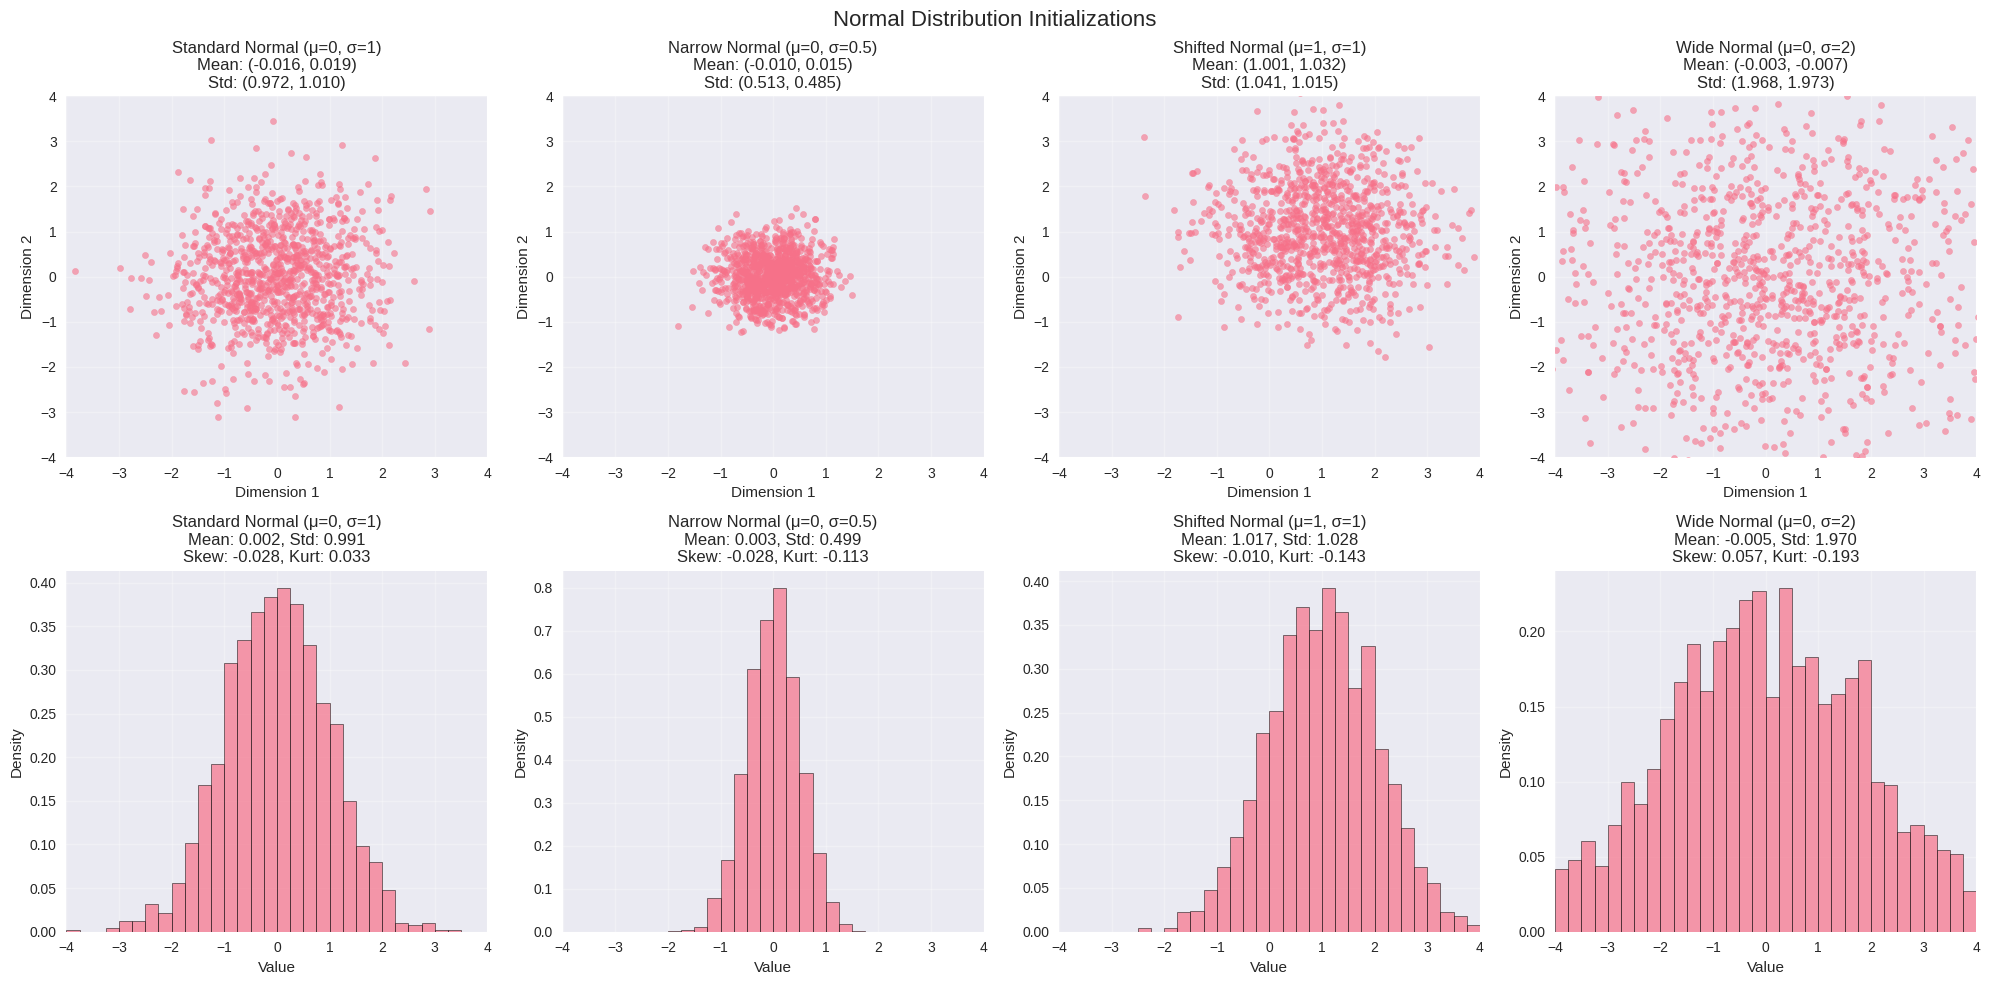

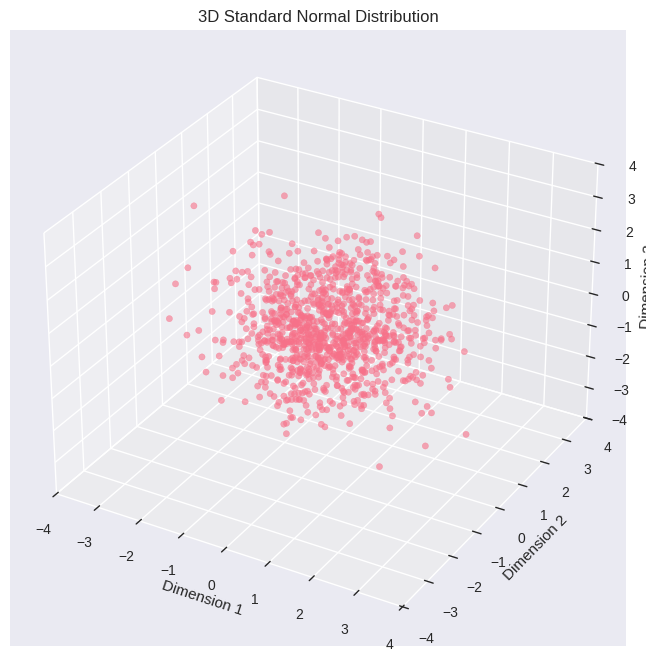

In [247]:
print("=== NORMAL DISTRIBUTION DEMONSTRATION ===")

# Use CPU device for consistency
device = torch.device('cpu')

# Create normal distributions with different parameters
normal_configs = [
    {'mean': torch.zeros(DIM_2D, device=device), 'cov': torch.eye(DIM_2D, device=device), 'title': 'Standard Normal (μ=0, σ=1)'},
    {'mean': torch.zeros(DIM_2D, device=device), 'cov': 0.5**2 * torch.eye(DIM_2D, device=device), 'title': 'Narrow Normal (μ=0, σ=0.5)'},
    {'mean': torch.ones(DIM_2D, device=device), 'cov': torch.eye(DIM_2D, device=device), 'title': 'Shifted Normal (μ=1, σ=1)'},
    {'mean': torch.zeros(DIM_2D, device=device), 'cov': 2.0**2 * torch.eye(DIM_2D, device=device), 'title': 'Wide Normal (μ=0, σ=2)'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Normal Distribution Initializations', fontsize=16)

for i, config in enumerate(normal_configs):
    # Create representation layer
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='normal',
        dist_params={'mean': config['mean'], 'cov': config['cov']},
        device=device
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with consistent limits
    plot_2d_scatter(layer.z, config['title'], axes[0, i])
    axes[0, i].set_xlim(-4, 4)
    axes[0, i].set_ylim(-4, 4)
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-4, 4), bin_width=0.25)

plt.tight_layout()
plt.show()

# 3D visualization for standard normal
layer_3d = RepresentationLayer(dim=DIM_3D, n_samples=N_SAMPLES, dist='normal', device=device)
fig, ax = plot_3d_scatter(layer_3d.z, '3D Standard Normal Distribution')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
plt.show()

## Multivariate Uniform Distribution Initialization

The **multivariate uniform distribution** is a generalization of the univariate uniform distribution to higher dimensions, where each component is independently uniformly distributed.

### Mathematical Definition

**Probability Density Function:**
$$f(\mathbf{x}) = \begin{cases} 
\prod_{i=1}^k \frac{1}{b_i - a_i} & \text{if } a_i \leq x_i \leq b_i \text{ for all } i \\
0 & \text{otherwise}
\end{cases}$$

**Parameters:**
- $a_i, b_i \in \mathbb{R}$ — **bounds** for dimension $i$ with $a_i < b_i$
- Support: $\mathbf{x} \in [a_1, b_1] \times [a_2, b_2] \times \cdots \times [a_k, b_k]$

**Properties:**
- **Mean:** $\mathbb{E}[X_i] = \frac{a_i + b_i}{2}$
- **Variance:** $\text{Var}[X_i] = \frac{(b_i - a_i)^2}{12}$
- **Mode:** All points in the support are modes (constant density)
- **Independence:** Components are independent: $f(\mathbf{x}) = \prod_{i=1}^k f_i(x_i)$

### Distribution Characteristics
- **Shape**: Rectangular hypercube with constant probability density
- **Bounded Support**: All values are strictly within specified bounds
- **Equal Probability**: All points in the support are equally likely
- **Use cases**: Bounded initial values, initialization for bounded activation functions
- **Sampling**: Simple to generate - transform uniform(0,1) samples

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **low**: scalar $\rightarrow$ same lower bound for all dimensions
- **high**: scalar $\rightarrow$ same upper bound for all dimensions

=== UNIFORM DISTRIBUTION DEMONSTRATION ===

Standard Uniform [-1, 1] Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0064
Std: 0.5790
Min: -0.9993
Max: 0.9995
Skewness: 0.0019
Kurtosis: -1.1442
----------------------------------------

Narrow Uniform [-0.5, 0.5] Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0050
Std: 0.2882
Min: -0.4989
Max: 0.4992
Skewness: 0.0430
Kurtosis: -1.2120
----------------------------------------

Positive Uniform [0, 2] Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 1.0021
Std: 0.5768
Min: 0.0001
Max: 1.9992
Skewness: 0.0061
Kurtosis: -1.1912
----------------------------------------

Wide Uniform [-2, 2] Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0632
Std: 1.1455
Min: -1.9994
Max: 1.9954
Skewness: 0.0318
Kurtosis: -1.1858
----------------------------------------


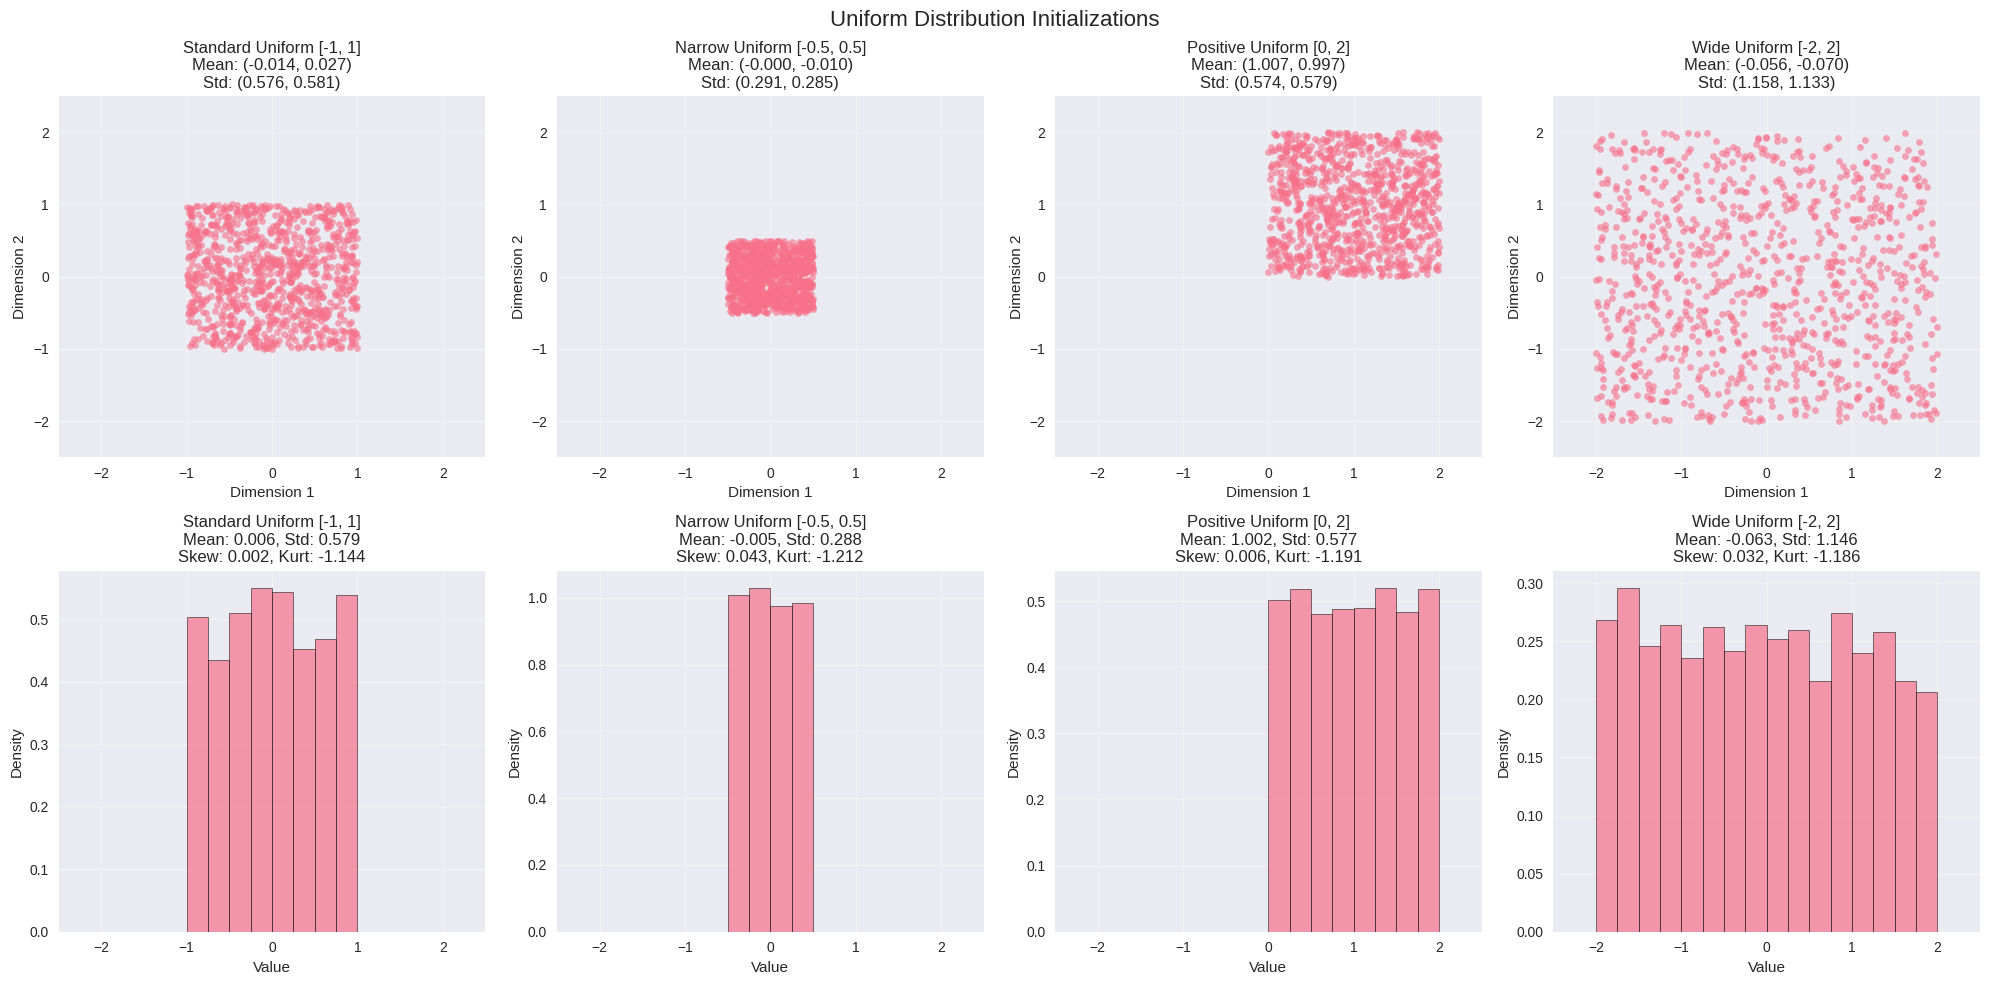

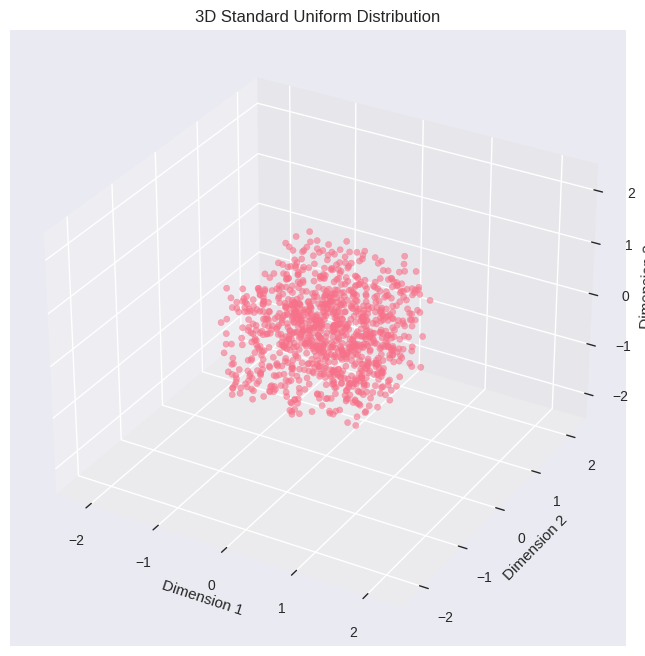

In [248]:
print("=== UNIFORM DISTRIBUTION DEMONSTRATION ===")

# Create uniform distributions with different bounds
uniform_configs = [
    {'low': -1.0, 'high': 1.0, 'title': 'Standard Uniform [-1, 1]'},
    {'low': -0.5, 'high': 0.5, 'title': 'Narrow Uniform [-0.5, 0.5]'},
    {'low': 0.0, 'high': 2.0, 'title': 'Positive Uniform [0, 2]'},
    {'low': -2.0, 'high': 2.0, 'title': 'Wide Uniform [-2, 2]'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Uniform Distribution Initializations', fontsize=16)

for i, config in enumerate(uniform_configs):
    # Create representation layer
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='uniform',
        dist_params={'low': config['low'], 'high': config['high']}
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with consistent limits
    plot_2d_scatter(layer.z, config['title'], axes[0, i])
    axes[0, i].set_xlim(-2.5, 2.5)
    axes[0, i].set_ylim(-2.5, 2.5)
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-2.5, 2.5), bin_width=0.25)

plt.tight_layout()
plt.show()

# 3D visualization for standard uniform
layer_3d = RepresentationLayer(dim=DIM_3D, n_samples=N_SAMPLES, dist='uniform')
fig, ax = plot_3d_scatter(layer_3d.z, '3D Standard Uniform Distribution')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)
plt.show()

## Multivariate Uniform ball Distribution Initialization

The **uniform ball distribution** generates points uniformly distributed within a $k$-dimensional hyperball (ball). This distribution has **spherical symmetry** and **bounded norm**.

### Mathematical Definition

**Support:**
$$\mathbf{x} \in \{\mathbf{y} \in \mathbb{R}^k : \|\mathbf{y}\| \leq r\}$$

**Probability Density Function:**
$$f(\mathbf{x}) = \begin{cases} 
\frac{\Gamma(k/2 + 1)}{\pi^{k/2} r^k} & \text{if } \|\mathbf{x}\| \leq r \\
0 & \text{otherwise}
\end{cases}$$

**Parameters:**
- $r > 0$ — **radius** of the hyperball
- $k$ — **dimension** of the space

**Properties:**
- **Mean:** $\mathbb{E}[\mathbf{X}] = \mathbf{0}$ (by symmetry)
- **Variance:** $\text{Var}[X_i] = \frac{r^2}{k+2}$ for each component
- **Volume:** $V_k(r) = \frac{\pi^{k/2}}{\Gamma(k/2 + 1)} r^k$
- **Norm constraint:** $\|\mathbf{X}\| \leq r$ almost surely

### Distribution Characteristics
- **Shape**: Uniform density within a hyperball, zero density outside
- **Spherical symmetry**: Invariant under orthogonal transformations
- **Concentration**: In high dimensions, most mass concentrates near the boundary
- **Radial distribution**: $R = \|\mathbf{X}\|$ follows $R^{k-1}$ distribution on $[0,r]$
- **Use cases**: Norm-constrained initialization, spherically symmetric priors

### Generation Algorithm
1. Generate $\mathbf{Z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_k)$ (standard normal)
2. Generate $U \sim \text{Uniform}(0,1)$
3. Return $\mathbf{X} = r \cdot U^{1/k} \cdot \frac{\mathbf{Z}}{\|\mathbf{Z}\|}$

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **radius**: scalar $\rightarrow$ radius of the hyperball for all dimensions

=== UNIFORM ball DISTRIBUTION DEMONSTRATION ===

Unit ball (r=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0082
Std: 0.5007
Min: -0.9880
Max: 0.9886
Skewness: 0.0086
Kurtosis: -1.0300
----------------------------------------

Small ball (r=0.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0040
Std: 0.2499
Min: -0.4949
Max: 0.4996
Skewness: 0.0184
Kurtosis: -1.0023
----------------------------------------

Large ball (r=2) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0223
Std: 1.0036
Min: -1.9560
Max: 1.9996
Skewness: -0.0047
Kurtosis: -0.9683
----------------------------------------

Medium ball (r=1.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0038
Std: 0.7399
Min: -1.4985
Max: 1.4924
Skewness: 0.0259
Kurtosis: -0.9622
----------------------------------------


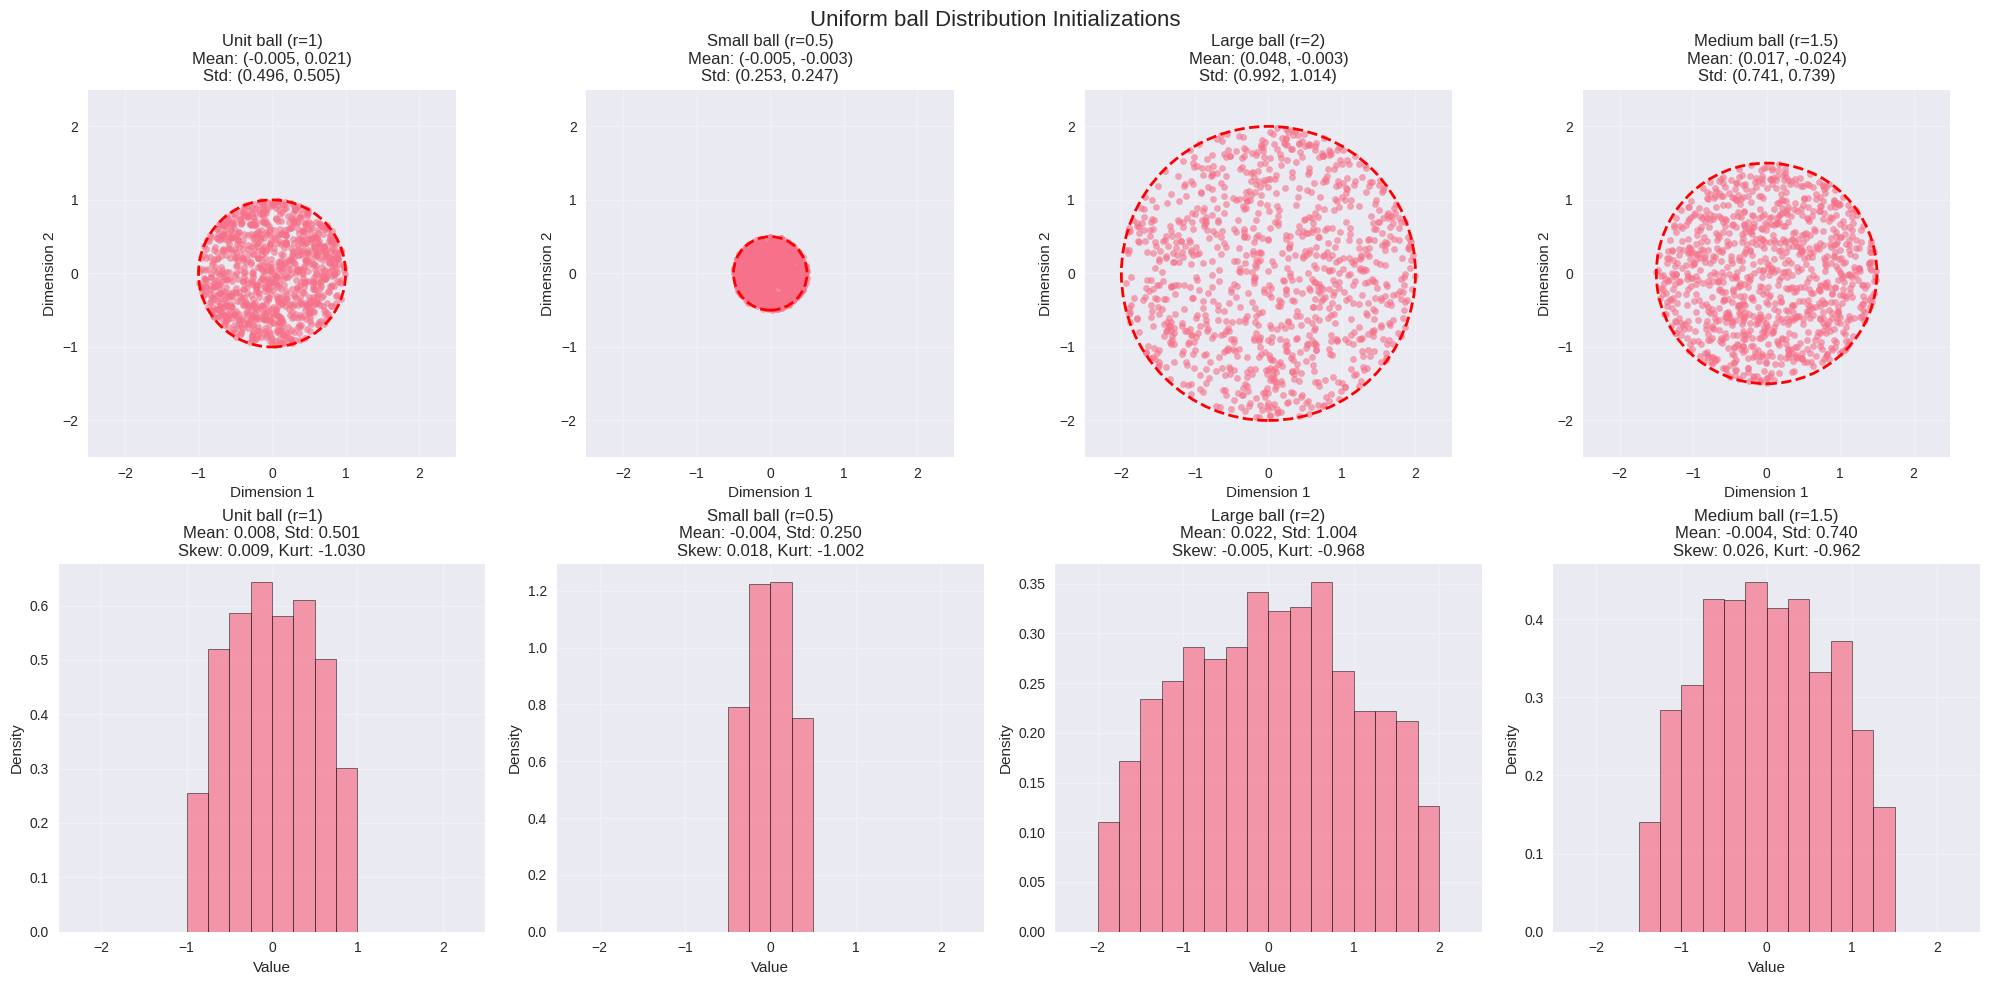

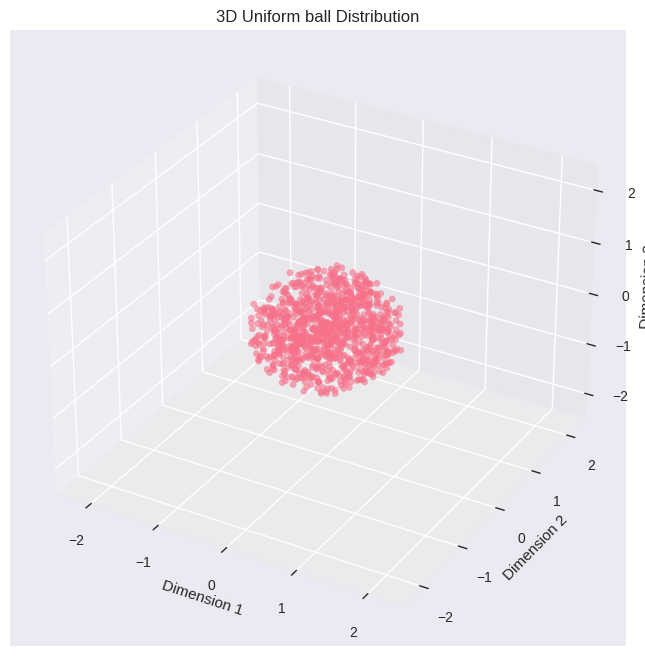


Distance verification for 3D unit ball:
Max distance: 0.9999 (should be ≤ 1.0)
Mean distance: 0.7423
Points within unit ball: 1000/1000


In [249]:
print("=== UNIFORM ball DISTRIBUTION DEMONSTRATION ===")

# Create uniform ball distributions with different radii
ball_configs = [
    {'radius': 1.0, 'title': 'Unit ball (r=1)'},
    {'radius': 0.5, 'title': 'Small ball (r=0.5)'},
    {'radius': 2.0, 'title': 'Large ball (r=2)'},
    {'radius': 1.5, 'title': 'Medium ball (r=1.5)'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Uniform ball Distribution Initializations', fontsize=16)

for i, config in enumerate(ball_configs):
    # Create representation layer
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='uniform_ball',
        dist_params={'radius': config['radius']}
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with circle overlay and consistent limits
    ax = plot_2d_scatter(layer.z, config['title'], axes[0, i])
    circle = plt.Circle((0, 0), config['radius'], fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_patch(circle)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-2.5, 2.5), bin_width=0.25)

plt.tight_layout()
plt.show()

# 3D visualization for unit ball
layer_3d = RepresentationLayer(dim=DIM_3D, n_samples=N_SAMPLES, dist='uniform_ball')
fig, ax = plot_3d_scatter(layer_3d.z, '3D Uniform ball Distribution')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)
plt.show()

# Verify points are within the ball
distances = torch.norm(layer_3d.z, dim=1)
print(f"\nDistance verification for 3D unit ball:")
print(f"Max distance: {distances.max().detach():.4f} (should be ≤ 1.0)")
print(f"Mean distance: {distances.mean().detach():.4f}")
print(f"Points within unit ball: {(distances <= 1.0).sum().item()}/{len(distances)}")

## Multivariate Uniform Sphere Distribution Initialization

The **uniform sphere distribution** generates points uniformly distributed on the surface of a $k$-dimensional hypersphere. This distribution has **spherical symmetry** and **constant norm**.

### Mathematical Definition

**Support:**
$$\mathbf{x} \in \{\mathbf{y} \in \mathbb{R}^k : \|\mathbf{y}\| = r\}$$

**Probability Density Function:**
$$f(\mathbf{x}) = \begin{cases} 
\frac{\Gamma(k/2 + 1)}{\pi^{k/2} r^{k-1}} \delta(\|\mathbf{x}\| - r) & \text{if } \|\mathbf{x}\| = r \\
0 & \text{otherwise}
\end{cases}$$

**Parameters:**
- $r > 0$ — **radius** of the hypersphere surface
- $k$ — **dimension** of the ambient space

**Properties:**
- **Mean:** $\mathbb{E}[\mathbf{X}] = \mathbf{0}$ (by symmetry)
- **Variance:** $\text{Var}[X_i] = \frac{r^2}{k}$ for each component
- **Surface Area:** $S_k(r) = \frac{2\pi^{k/2}}{\Gamma(k/2)} r^{k-1}$
- **Norm constraint:** $\|\mathbf{X}\| = r$ almost surely

### Distribution Characteristics
- **Shape**: Uniform density on sphere surface, zero density elsewhere
- **Spherical symmetry**: Invariant under orthogonal transformations
- **Concentration**: In high dimensions, most mass concentrates around the equator
- **Difference from ball**: Points are on the surface, not inside the volume
- **Use cases**: Direction vectors, surface sampling, spherical coordinates

### Generation Algorithm (Muller Method)
1. Generate $\mathbf{Z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_k)$ (standard normal)
2. Normalize: $\mathbf{U} = \frac{\mathbf{Z}}{\|\mathbf{Z}\|}$ (uniform on unit sphere surface)
3. Scale: $\mathbf{X} = r \cdot \mathbf{U}$

This works because the multivariate normal distribution is **rotationally invariant**, and there is only one rotationally invariant distribution on the sphere surface: the uniform distribution.

### Key Difference from Uniform Ball
- **Uniform Ball**: Points distributed throughout the volume (density ∝ constant)
- **Uniform Sphere**: Points distributed only on the surface (density ∝ δ-function)

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **radius**: scalar $\rightarrow$ radius of the hypersphere surface for all dimensions

=== UNIFORM SPHERE DISTRIBUTION DEMONSTRATION ===

Unit sphere (r=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0030
Std: 0.7071
Min: -1.0000
Max: 1.0000
Skewness: 0.0141
Kurtosis: -1.4723
----------------------------------------

Small sphere (r=0.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0063
Std: 0.3535
Min: -0.5000
Max: 0.5000
Skewness: 0.0379
Kurtosis: -1.5080
----------------------------------------

Large sphere (r=2) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0366
Std: 1.4137
Min: -2.0000
Max: 2.0000
Skewness: -0.0361
Kurtosis: -1.4929
----------------------------------------

Medium sphere (r=1.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0282
Std: 1.0603
Min: -1.5000
Max: 1.5000
Skewness: -0.0423
Kurtosis: -1.4992
----------------------------------------

Unit sphere (r=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0030
Std: 0.7071
Min: -1.0000
Max: 1.0000
Skewness: 0.0141
K

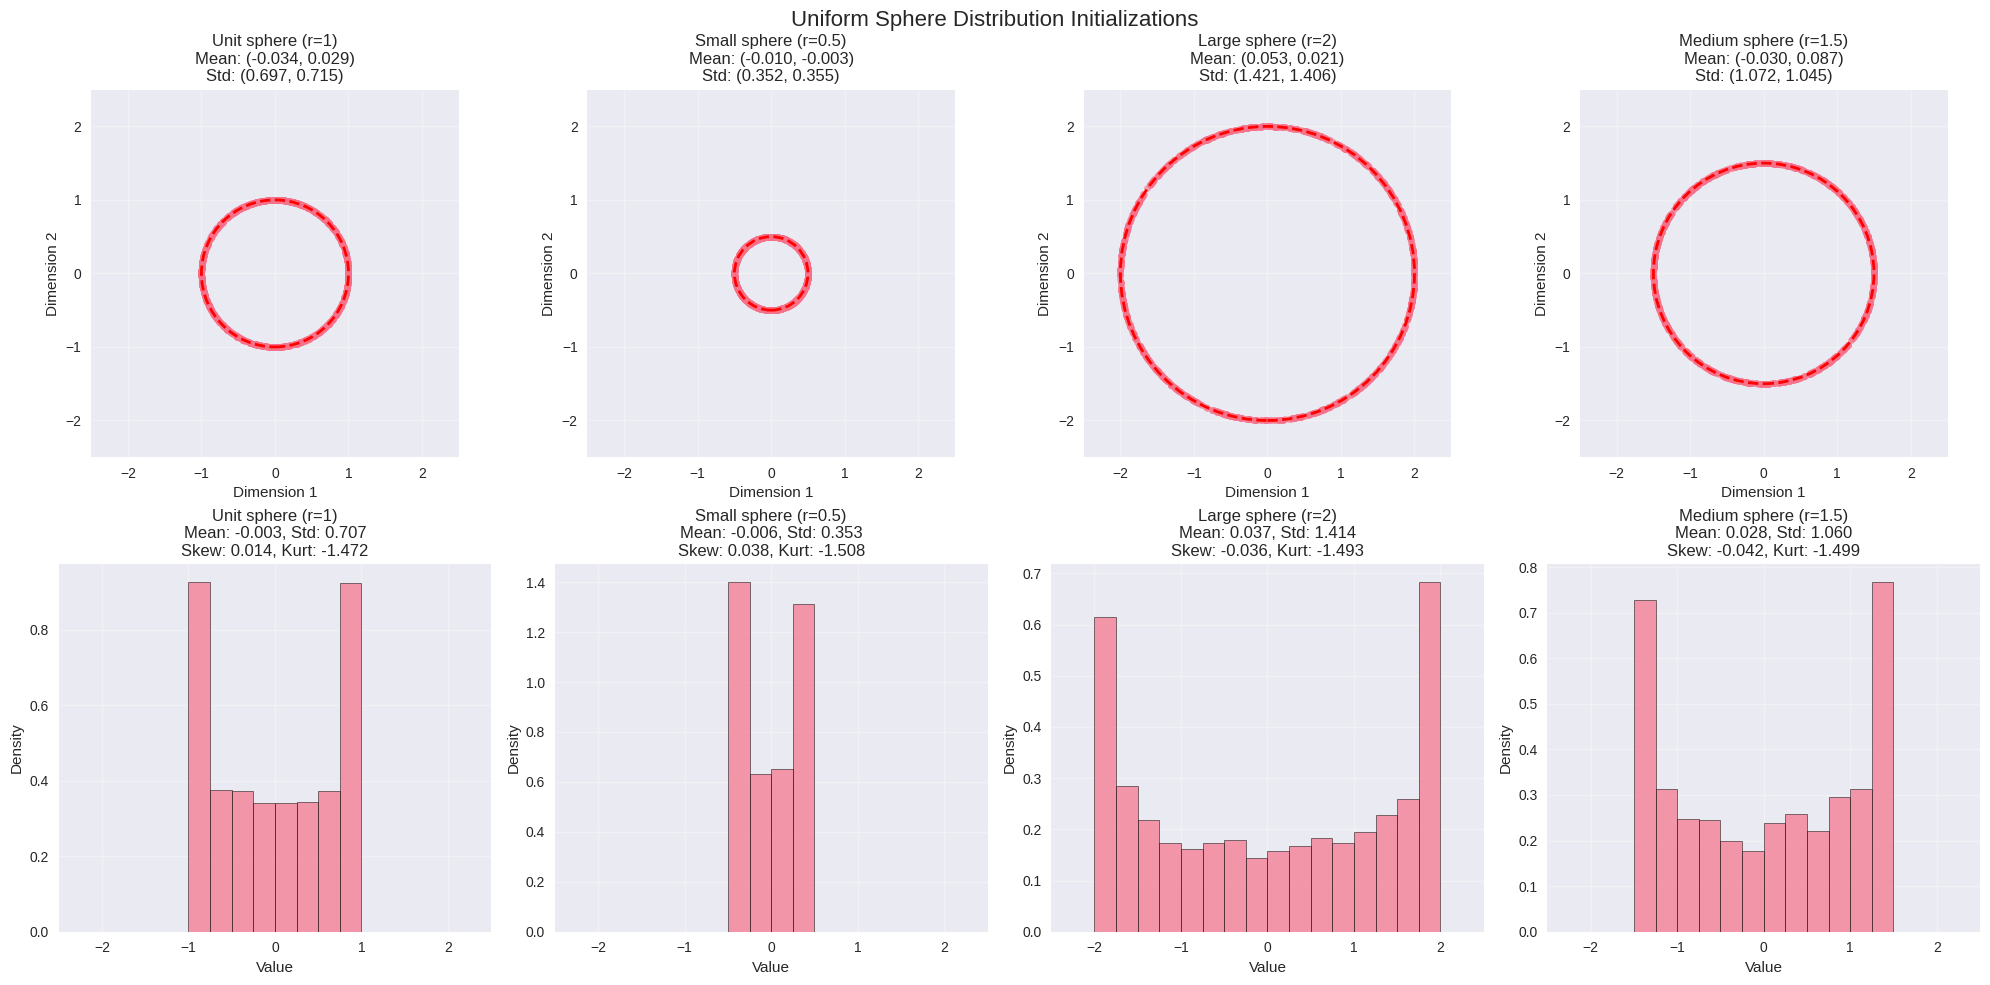

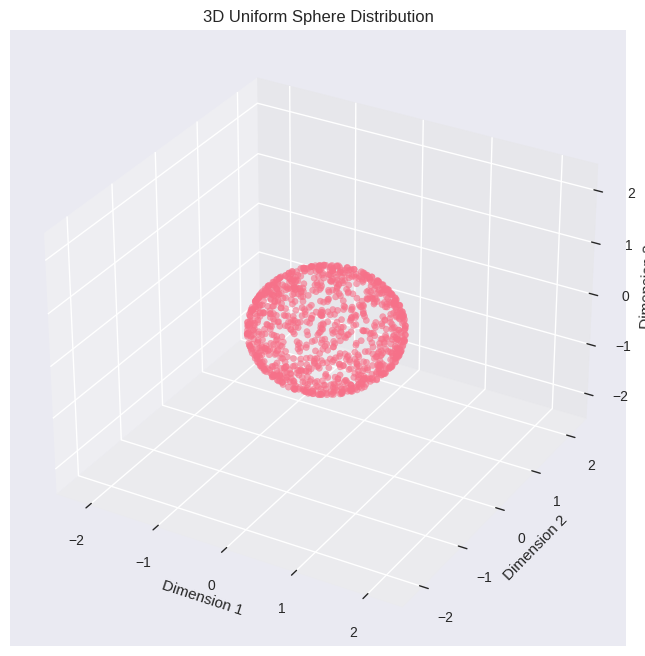


Distance verification for 3D unit sphere:
Max distance: 1.000000 (should be ≈ 1.0)
Min distance: 1.000000 (should be ≈ 1.0)
Mean distance: 1.000000 (should be ≈ 1.0)
Std distance: 0.000000 (should be ≈ 0.0)
Distance range: [1.000000, 1.000000]


In [250]:
print("=== UNIFORM SPHERE DISTRIBUTION DEMONSTRATION ===")

# Create uniform sphere distributions with different radii
sphere_configs = [
    {'radius': 1.0, 'title': 'Unit sphere (r=1)'},
    {'radius': 0.5, 'title': 'Small sphere (r=0.5)'},
    {'radius': 2.0, 'title': 'Large sphere (r=2)'},
    {'radius': 1.5, 'title': 'Medium sphere (r=1.5)'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Uniform Sphere Distribution Initializations', fontsize=16)

for i, config in enumerate(sphere_configs):
    # Create representation layer
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='uniform_sphere',
        dist_params={'radius': config['radius']}
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with circle overlay and consistent limits
    ax = plot_2d_scatter(layer.z, config['title'], axes[0, i])
    circle = plt.Circle((0, 0), config['radius'], fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_patch(circle)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-2.5, 2.5), bin_width=0.25)

plt.tight_layout()
plt.show()

# 3D visualization for unit sphere
layer_3d = RepresentationLayer(dim=DIM_3D, n_samples=N_SAMPLES, dist='uniform_sphere')
fig, ax = plot_3d_scatter(layer_3d.z, '3D Uniform Sphere Distribution')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)
plt.show()

# Verify all points are exactly on the sphere surface
distances = torch.norm(layer_3d.z, dim=1)
print(f"\nDistance verification for 3D unit sphere:")
print(f"Max distance: {distances.max().detach():.6f} (should be ≈ 1.0)")
print(f"Min distance: {distances.min().detach():.6f} (should be ≈ 1.0)")
print(f"Mean distance: {distances.mean().detach():.6f} (should be ≈ 1.0)")
print(f"Std distance: {distances.std().detach():.6f} (should be ≈ 0.0)")
print(f"Distance range: [{distances.min().detach():.6f}, {distances.max().detach():.6f}]")

## Multivariate Laplace Distribution Initialization

The **multivariate Laplace distribution** (also called **multivariate double exponential**) is a generalization of the univariate Laplace distribution to multiple dimensions, featuring heavier tails than the normal distribution.

### Mathematical Definition

**Probability Density Function:**
$$f(\mathbf{x}) = \frac{2}{(2\pi)^{k/2}|\boldsymbol{\Sigma}|^{1/2}} \left(\frac{(\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})}{2}\right)^{v/2} K_v\left(\sqrt{2(\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})}\right)$$

where $v = (2-k)/2$ and $K_v$ is the **modified Bessel function of the second kind**.

**Parameters:**
- $\boldsymbol{\mu} \in \mathbb{R}^k$ — **location vector** (mean)
- $\boldsymbol{\Sigma} \in \mathbb{R}^{k \times k}$ — **scale matrix** (positive definite)

**Properties:**
- **Mean:** $\mathbb{E}[\mathbf{X}] = \boldsymbol{\mu}$
- **Covariance:** $\text{Cov}[\mathbf{X}] = \boldsymbol{\Sigma}$
- **Mode:** $\boldsymbol{\mu}$
- **Symmetry:** Symmetric around $\boldsymbol{\mu}$

### Distribution Characteristics
- **Shape**: Double exponential with sharp peak at center, heavier tails than normal
- **Tail behavior**: Exponential decay vs. Gaussian quadratic decay
- **Sparsity promotion**: Encourages sparse representations due to peaked density
- **Robust estimation**: Less sensitive to outliers than normal distribution
- **Use cases**: Sparse neural representations, robust initialization, L1-type priors

### Special Cases

**Bivariate case** ($k = 2$, $\boldsymbol{\mu} = \mathbf{0}$):
$$f(x_1, x_2) = \frac{1}{\pi\sigma_1\sigma_2\sqrt{1-\rho^2}} K_0\left(\sqrt{\frac{2\left(\frac{x_1^2}{\sigma_1^2} - \frac{2\rho x_1 x_2}{\sigma_1\sigma_2} + \frac{x_2^2}{\sigma_2^2}\right)}{1-\rho^2}}\right)$$

**Uncorrelated bivariate case** ($\rho = 0$, $\sigma_1 = \sigma_2 = 1$):
$$f(x_1, x_2) = \frac{1}{\pi} K_0\left(\sqrt{2(x_1^2 + x_2^2)}\right)$$

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **loc**: scalar $\rightarrow$ $[\text{loc}, \text{loc}, \ldots, \text{loc}]^T$
- **scale_matrix**: scalar $\rightarrow$ $\text{scalar} \times \mathbf{I}_k$ (spherical scale matrix)

=== LAPLACE DISTRIBUTION DEMONSTRATION ===

Standard Laplace (μ=0, σ=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0076
Std: 0.9846
Min: -6.0954
Max: 5.2365
Skewness: -0.0332
Kurtosis: 2.9654
----------------------------------------

Narrow Laplace (μ=0, σ=0.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0148
Std: 0.4878
Min: -2.4705
Max: 2.1298
Skewness: -0.1992
Kurtosis: 2.3891
----------------------------------------

Shifted Laplace (μ=1, σ=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.9994
Std: 1.0036
Min: -3.6481
Max: 6.6190
Skewness: -0.0883
Kurtosis: 2.8805
----------------------------------------

Wide Laplace (μ=0, σ=2) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0381
Std: 1.9591
Min: -9.7375
Max: 10.8449
Skewness: 0.1507
Kurtosis: 2.8938
----------------------------------------


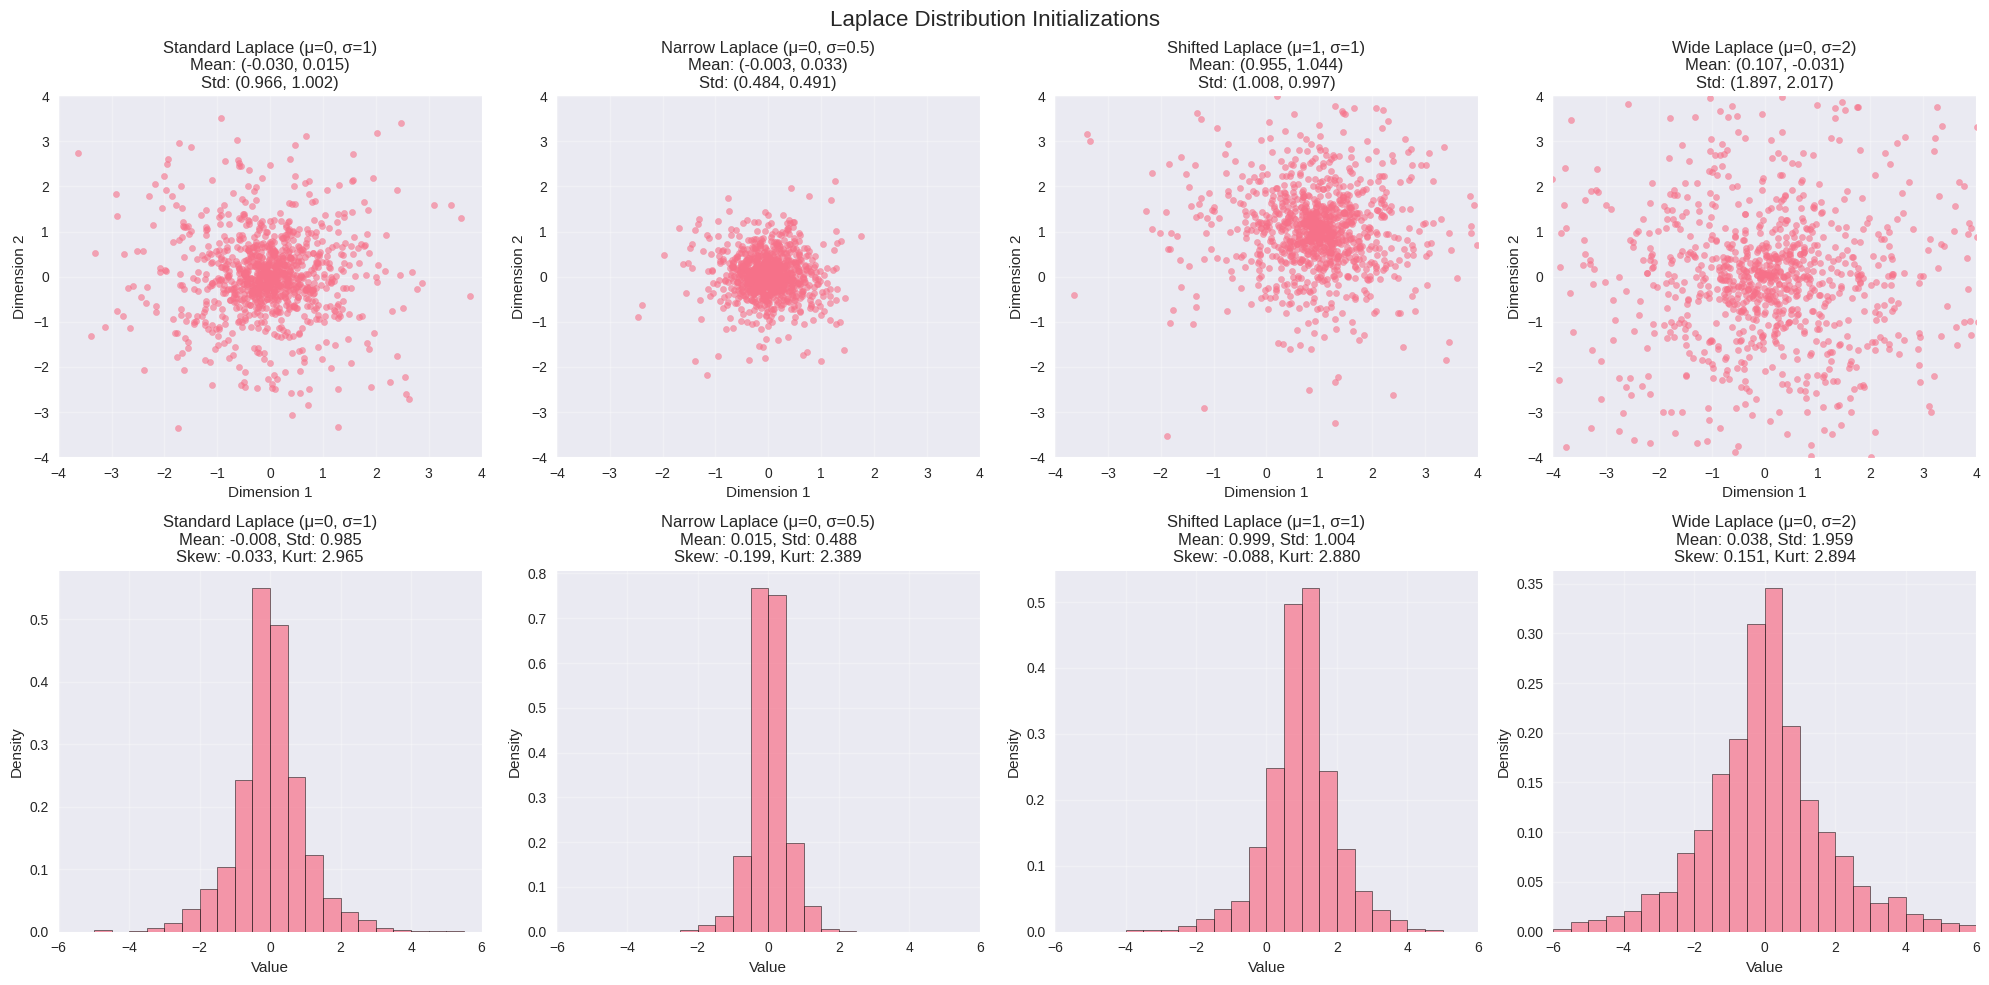

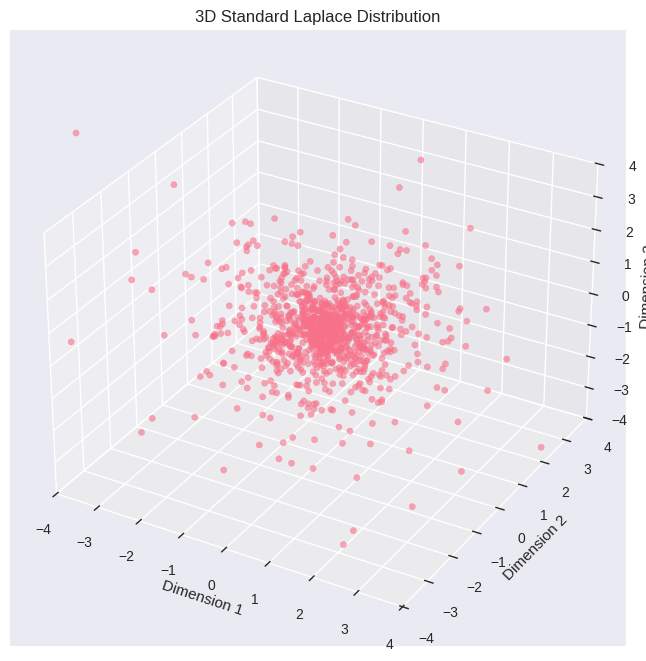

In [251]:
print("=== LAPLACE DISTRIBUTION DEMONSTRATION ===")

# Use CPU device for now to avoid device conflicts  
device = torch.device('cpu')

# Create Laplace distributions with different parameters
laplace_configs = [
    {'loc': torch.zeros(DIM_2D, device=device), 'scale_matrix': torch.eye(DIM_2D, device=device), 'title': 'Standard Laplace (μ=0, σ=1)'},
    {'loc': torch.zeros(DIM_2D, device=device), 'scale_matrix': 0.5**2 * torch.eye(DIM_2D, device=device), 'title': 'Narrow Laplace (μ=0, σ=0.5)'},
    {'loc': torch.ones(DIM_2D, device=device), 'scale_matrix': torch.eye(DIM_2D, device=device), 'title': 'Shifted Laplace (μ=1, σ=1)'},
    {'loc': torch.zeros(DIM_2D, device=device), 'scale_matrix': 2.0**2 * torch.eye(DIM_2D, device=device), 'title': 'Wide Laplace (μ=0, σ=2)'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Laplace Distribution Initializations', fontsize=16)

for i, config in enumerate(laplace_configs):
    # Create representation layer on CPU device
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='laplace',
        dist_params={'loc': config['loc'], 'scale_matrix': config['scale_matrix']},
        device=device
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with consistent limits
    plot_2d_scatter(layer.z, config['title'], axes[0, i])
    axes[0, i].set_xlim(-4, 4)
    axes[0, i].set_ylim(-4, 4)
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-6, 6), bin_width=0.5)

plt.tight_layout()
plt.show()

# 3D visualization for standard Laplace
layer_3d = RepresentationLayer(dim=DIM_3D, n_samples=N_SAMPLES, dist='laplace', device=device)
fig, ax = plot_3d_scatter(layer_3d.z, '3D Standard Laplace Distribution')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
plt.show()

## Multivariate Student's t-Distribution Initialization

The **multivariate Student's t-distribution** is a generalization of the univariate Student's t-distribution to multiple dimensions. It features **heavy tails** and approaches the multivariate normal distribution as degrees of freedom increase.

### Mathematical Definition

**Probability Density Function:**
$$f(\mathbf{x}) = \frac{\Gamma[(\nu+k)/2]}{\Gamma(\nu/2)\nu^{k/2}\pi^{k/2}|\boldsymbol{\Sigma}|^{1/2}} \left[1 + \frac{1}{\nu}(\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\right]^{-(\nu+k)/2}$$

**Parameters:**
- $\boldsymbol{\mu} \in \mathbb{R}^k$ — **location vector** (not the mean for $\nu \leq 1$)
- $\boldsymbol{\Sigma} \in \mathbb{R}^{k \times k}$ — **scale matrix** (positive definite)  
- $\nu > 0$ — **degrees of freedom** (shape parameter)

**Properties:**
- **Mean:** $\mathbb{E}[\mathbf{X}] = \boldsymbol{\mu}$ if $\nu > 1$; undefined otherwise
- **Covariance:** $\text{Cov}[\mathbf{X}] = \frac{\nu}{\nu-2}\boldsymbol{\Sigma}$ if $\nu > 2$; undefined otherwise
- **Mode:** $\boldsymbol{\mu}$
- **Median:** $\boldsymbol{\mu}$

### Constructive Definition

The multivariate t-distribution can be constructed as:
$$\mathbf{X} = \frac{\mathbf{Y}}{\sqrt{U/\nu}} + \boldsymbol{\mu}$$

where:
- $\mathbf{Y} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$ (multivariate normal)
- $U \sim \chi^2_\nu$ (chi-squared with $\nu$ degrees of freedom)
- $\mathbf{Y}$ and $U$ are independent

### Distribution Characteristics
- **Shape**: Bell-shaped like normal but with heavier tails
- **Tail behavior**: Polynomial decay $\propto ||\mathbf{x}||^{-(\nu+k)}$ vs. exponential for normal
- **Robustness**: More robust to outliers than normal distribution
- **Limiting behavior**: As $\nu \to \infty$, converges to $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$
- **Special case**: $\nu = 1$ gives multivariate Cauchy distribution

### Degrees of Freedom Effects
- **$\nu = 1$**: Cauchy-like, undefined mean and variance, very heavy tails
- **$\nu = 3$**: Heavy tails, finite variance
- **$\nu \geq 10$**: Approximately normal behavior
- **$\nu \to \infty$**: Exact multivariate normal limit

### Use Cases
- **Robust initialization**: When expecting outliers or heavy-tailed data
- **Bayesian priors**: Natural conjugate relationships
- **Financial modeling**: Asset returns with fat tails
- **Robust regression**: Less sensitive to outlying observations

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **scale_matrix**: scalar $\rightarrow$ $\text{scalar} \times \mathbf{I}_k$ (spherical scale matrix)

=== STUDENT'S T-DISTRIBUTION DEMONSTRATION ===

Cauchy-like t (df=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -1.8864
Std: 72.9585
Min: -2118.1294
Max: 1093.8696
Skewness: -21.4718
Kurtosis: 681.0157
----------------------------------------

Standard t (df=3) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0777
Std: 2.7411
Min: -26.5288
Max: 15.8181
Skewness: -0.5768
Kurtosis: 10.6227
----------------------------------------

Near-Normal t (df=10) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0463
Std: 3.6558
Min: -18.5689
Max: 15.2044
Skewness: 0.0113
Kurtosis: 1.1121
----------------------------------------

Scaled t (df=3, scale=0.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0424
Std: 1.3416
Min: -8.0750
Max: 9.4727
Skewness: 0.1595
Kurtosis: 6.3343
----------------------------------------


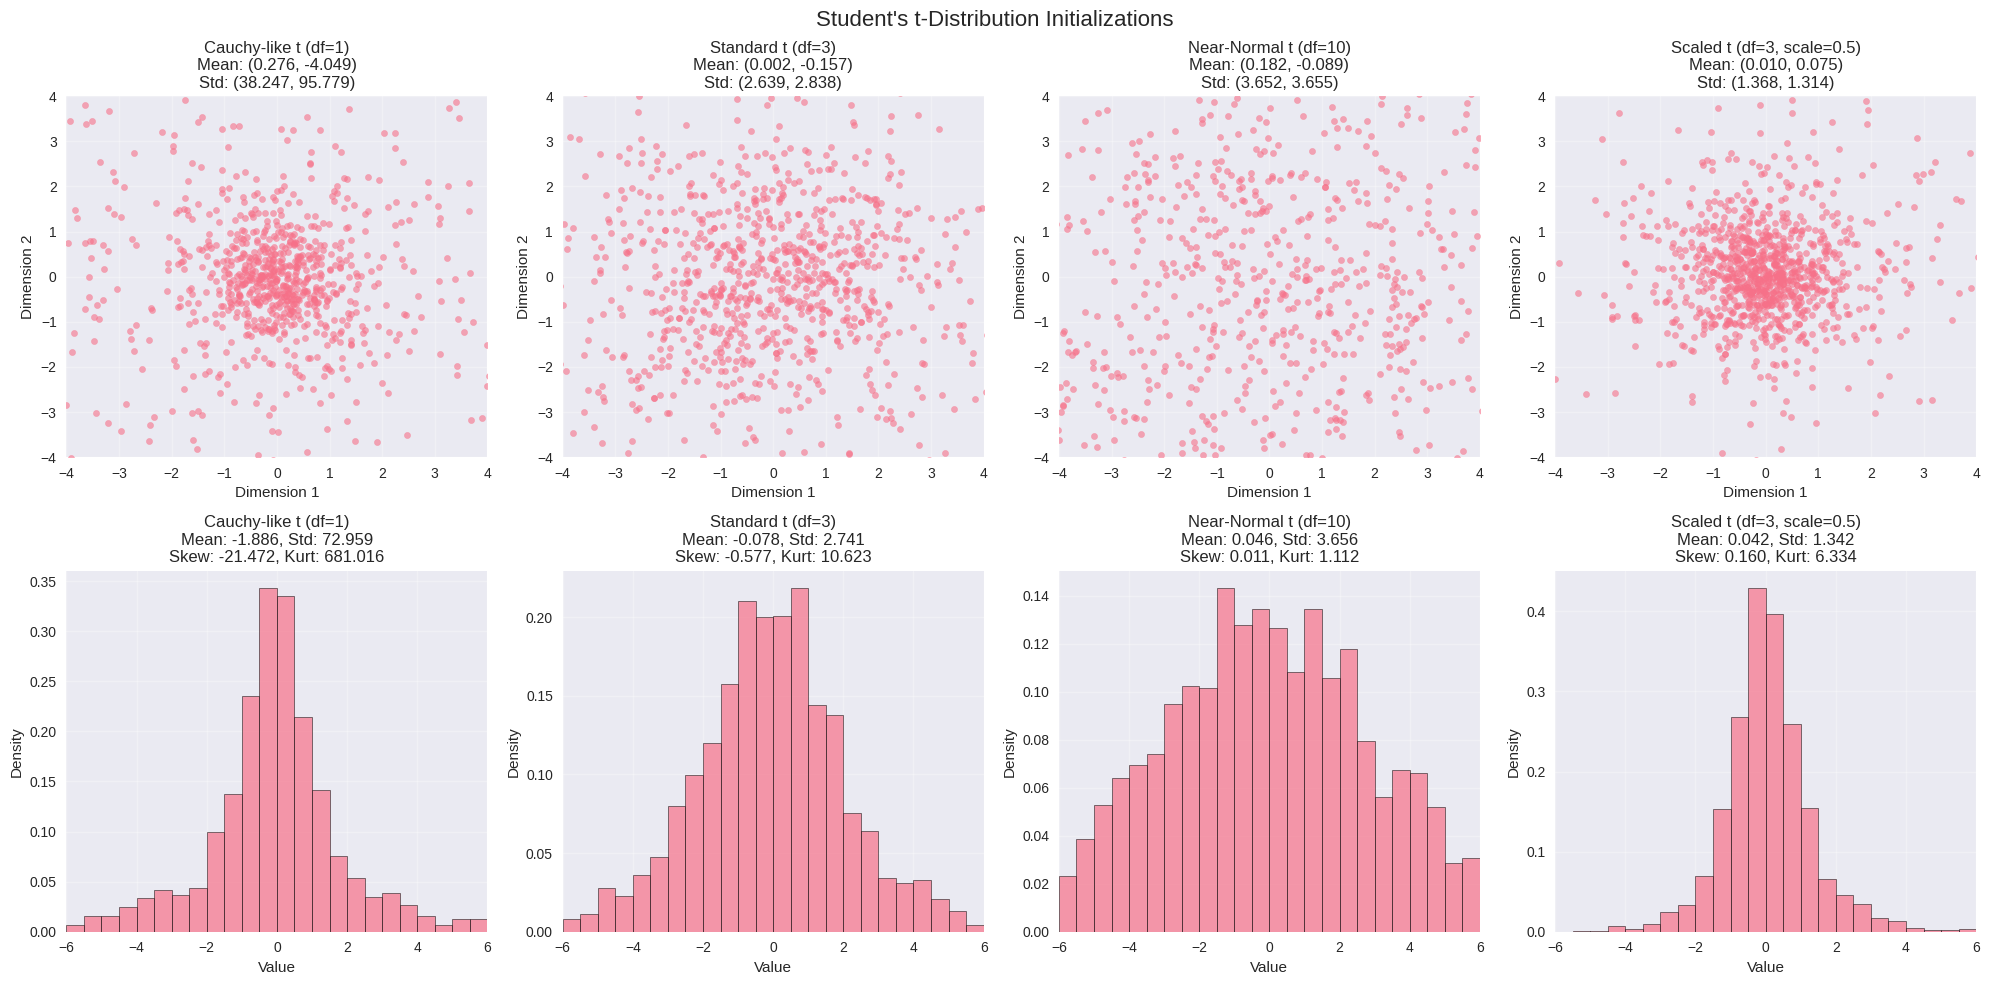

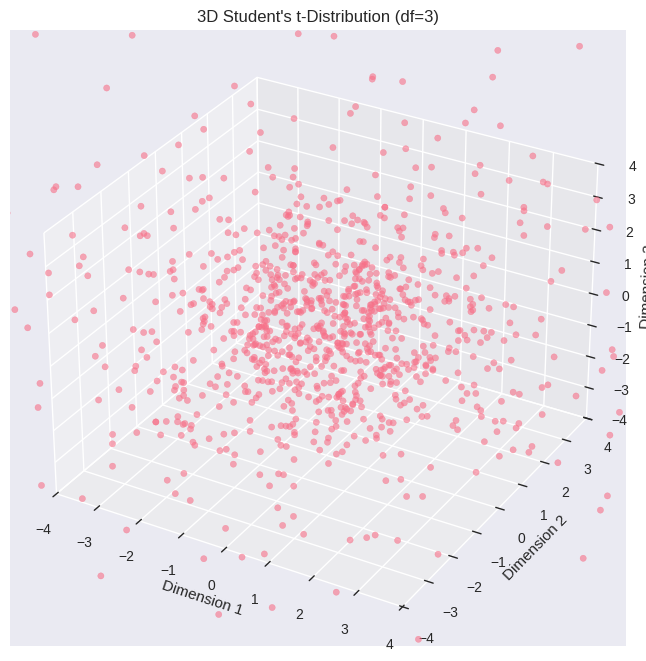

In [252]:
print("=== STUDENT'S T-DISTRIBUTION DEMONSTRATION ===")

# Use CPU device for consistency
device = torch.device('cpu')

# Create Student's t distributions with different parameters
t_configs = [
    {'df': 1.0, 'scale_matrix': torch.eye(DIM_2D, device=device), 'title': 'Cauchy-like t (df=1)'},
    {'df': 3.0, 'scale_matrix': torch.eye(DIM_2D, device=device), 'title': 'Standard t (df=3)'},
    {'df': 10.0, 'scale_matrix': torch.eye(DIM_2D, device=device), 'title': 'Near-Normal t (df=10)'},
    {'df': 3.0, 'scale_matrix': 0.5**2 * torch.eye(DIM_2D, device=device), 'title': 'Scaled t (df=3, scale=0.5)'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Student\'s t-Distribution Initializations', fontsize=16)

for i, config in enumerate(t_configs):
    # Create representation layer
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='student_t',
        dist_params={'df': config['df'], 'scale_matrix': config['scale_matrix']},
        device=device
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with consistent limits
    plot_2d_scatter(layer.z, config['title'], axes[0, i])
    axes[0, i].set_xlim(-4, 4)
    axes[0, i].set_ylim(-4, 4)
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-6, 6), bin_width=0.5)

plt.tight_layout()
plt.show()

# 3D visualization for standard t-distribution
layer_3d = RepresentationLayer(dim=DIM_3D, n_samples=N_SAMPLES, dist='student_t', device=device)
fig, ax = plot_3d_scatter(layer_3d.z, '3D Student\'s t-Distribution (df=3)')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
plt.show()

## Multivariate Hyperbolic Distribution Initialization

The **multivariate hyperbolic distribution** is a flexible distribution with **heavy tails** and **asymmetry** capabilities. It belongs to the generalized hyperbolic family and is constructed using a **normal-variance mixture**.

### Mathematical Definition

**Probability Density Function:**
$$f(\mathbf{x}) = \frac{(2\pi)^{-k/2}(\gamma/\delta)^{\lambda}}{\sqrt{|\boldsymbol{\Sigma}|}K_\lambda(\delta\gamma)} \left(\frac{\delta^2 + Q(\mathbf{x})}{\gamma^2}\right)^{(\lambda-k)/2} K_{\lambda-k/2}\left(\gamma\sqrt{\delta^2 + Q(\mathbf{x})}\right)$$

where:
- $Q(\mathbf{x}) = (\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})$ is the **Mahalanobis distance**
- $K_\nu$ is the **modified Bessel function of the second kind**
- $\gamma = \sqrt{\alpha^2 - \beta^2}$ is a **derived parameter**

**Parameters:**
- $\boldsymbol{\mu} \in \mathbb{R}^k$ — **location vector** (generalized mean)
- $\alpha > |\beta|$ — **tail heaviness parameter** (larger values → lighter tails)
- $\beta \in (-\alpha, \alpha)$ — **asymmetry parameter** (β = 0 gives symmetry)
- $\delta > 0$ — **scale parameter**
- $\lambda = 1$ — **shape parameter** (fixed for our implementation)

**Properties:**
- **Mean:** $\mathbb{E}[\mathbf{X}] = \boldsymbol{\mu} + \frac{\beta\delta^2}{\gamma} \frac{K_{\lambda+1}(\delta\gamma)}{K_\lambda(\delta\gamma)} \mathbf{1}$
- **Mode:** Approximately $\boldsymbol{\mu}$ for moderate parameters
- **Symmetry:** Symmetric around $\boldsymbol{\mu}$ when $\beta = 0$
- **Tail behavior:** Heavier than normal, lighter than Student's t

### Distribution Characteristics
- **Shape**: Bell-shaped with potentially **asymmetric heavy tails**
- **Flexibility**: Can model both light and heavy tails, symmetric and skewed data
- **Financial modeling**: Popular for modeling asset returns with skewness and kurtosis
- **Tail behavior**: Exponential decay, intermediate between normal and power law
- **Special cases**: 
  - $\beta = 0$: Symmetric hyperbolic distribution
  - $\alpha \to \infty$, $\beta = 0$: Approaches normal distribution
  - Various limits give Laplace, variance-gamma, etc.

### Normal-Variance Mixture Representation

The hyperbolic distribution can be represented as:
$$\mathbf{X} = \boldsymbol{\mu} + \frac{\beta\delta^2 W}{\gamma} + \delta\sqrt{W} \mathbf{Z}$$

where:
- $W \sim \text{GIG}(\lambda, \delta\gamma, \gamma)$ (Generalized Inverse Gaussian)
- $\mathbf{Z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_k)$ (standard multivariate normal)
- $W$ and $\mathbf{Z}$ are independent

### Generation Algorithm
1. Sample $W \sim \text{GIG}(\lambda, \delta\gamma, \gamma)$ (mixing variable)
2. Sample $\mathbf{Z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_k)$ (Gaussian component)
3. Construct: $\mathbf{X} = \boldsymbol{\mu} + \frac{\beta\delta^2 W}{\gamma} + \delta\sqrt{W} \mathbf{Z}$

**Note:** Our implementation uses a **Gamma approximation** for the GIG distribution to simplify sampling while maintaining reasonable accuracy for most parameter ranges.

### Use Cases
- **Financial data**: Asset returns with skewness and heavy tails
- **Robust initialization**: When data may have asymmetric outliers  
- **Physical modeling**: Natural phenomena with directional bias
- **Machine learning**: Robust priors for neural network weights

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **mu**: scalar $\rightarrow$ $[\text{mu}, \text{mu}, \ldots, \text{mu}]^T$
- **alpha**, **beta**, **delta**: scalars applied uniformly to all dimensions

=== HYPERBOLIC DISTRIBUTION DEMONSTRATION ===

(α=1.0, β=0, δ=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0387
Std: 1.0115
Min: -4.8846
Max: 5.1693
Skewness: 0.1886
Kurtosis: 2.4795
----------------------------------------

(α=3.0, β=0, δ=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0065
Std: 0.5730
Min: -2.6260
Max: 2.7822
Skewness: 0.1006
Kurtosis: 1.1471
----------------------------------------

(α=1.0, β=0, δ=2.0) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0024
Std: 2.7835
Min: -12.7156
Max: 13.9124
Skewness: 0.0454
Kurtosis: 1.4413
----------------------------------------

(α=2.0, β=0, δ=0.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0017
Std: 0.2447
Min: -1.0194
Max: 1.5750
Skewness: 0.2640
Kurtosis: 2.9278
----------------------------------------


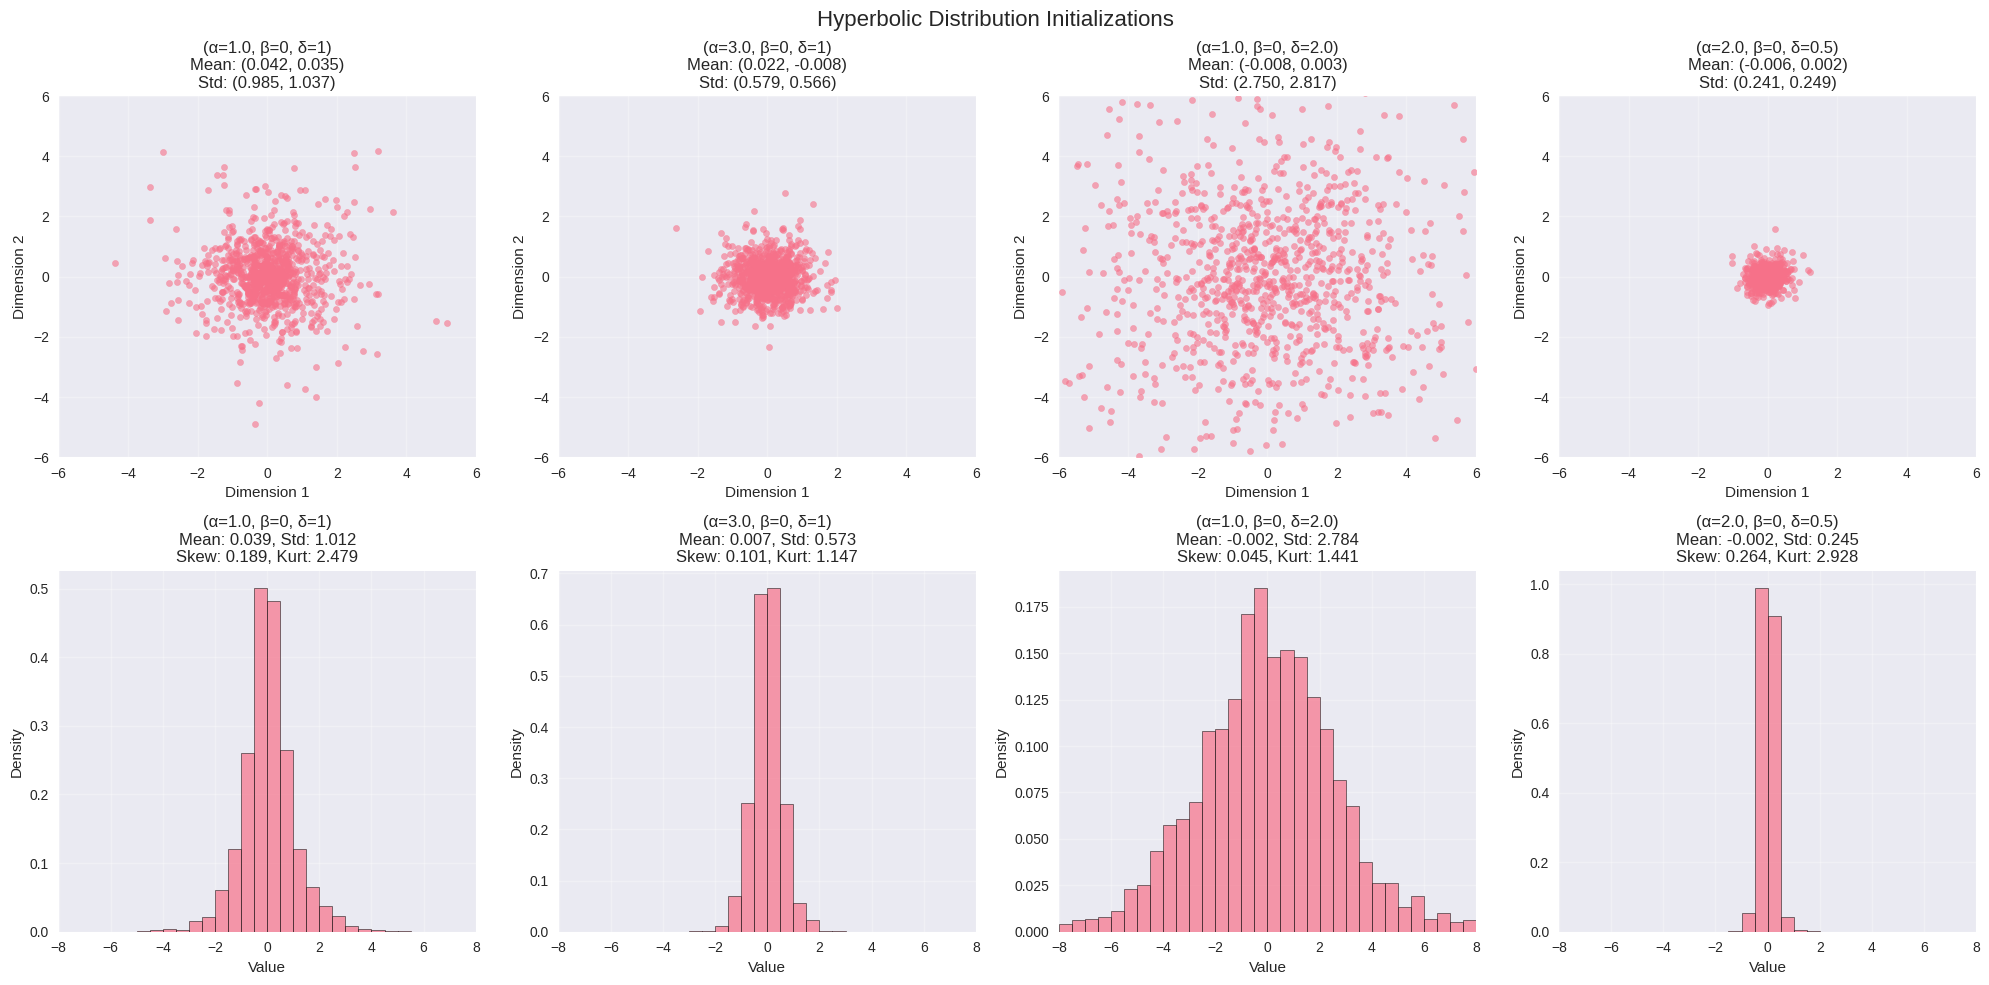

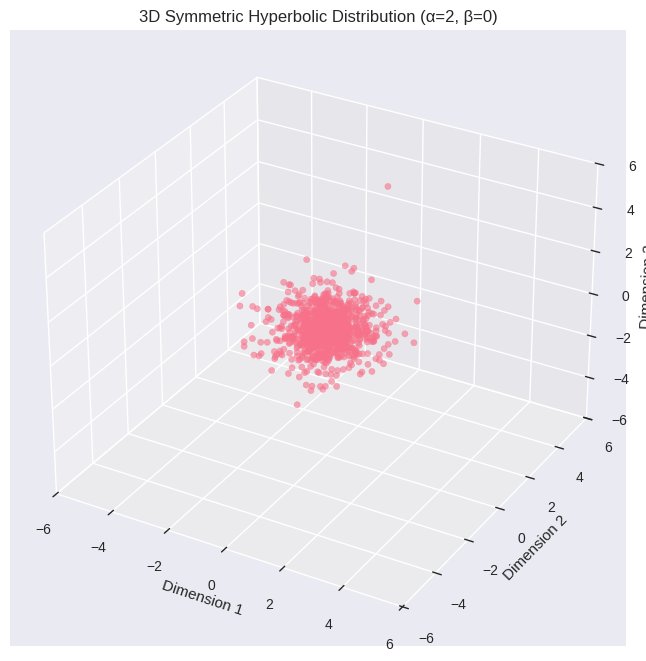

In [253]:
print("=== HYPERBOLIC DISTRIBUTION DEMONSTRATION ===")

# Use CPU device for consistency
device = torch.device('cpu')

# Create hyperbolic distributions with different parameters
hyperbolic_configs = [
    {'alpha': 1.0, 'beta': 0.0, 'delta': 1.0, 'title': '(α=1.0, β=0, δ=1)'},
    {'alpha': 3.0, 'beta': 0.0, 'delta': 1.0, 'title': '(α=3.0, β=0, δ=1)'},
    {'alpha': 1.0, 'beta': 0.0, 'delta': 2.0, 'title': '(α=1.0, β=0, δ=2.0)'},
    {'alpha': 2.0, 'beta': 0.0, 'delta': 0.5, 'title': '(α=2.0, β=0, δ=0.5)'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Hyperbolic Distribution Initializations', fontsize=16)

for i, config in enumerate(hyperbolic_configs):
    # Create representation layer
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='hyperbolic',
        dist_params={
            'alpha': config['alpha'], 
            'beta': config['beta'], 
            'delta': config['delta']
        },
        device=device
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with consistent limits
    plot_2d_scatter(layer.z, config['title'], axes[0, i])
    axes[0, i].set_xlim(-6, 6)
    axes[0, i].set_ylim(-6, 6)
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-8, 8), bin_width=0.5)

plt.tight_layout()
plt.show()

# 3D visualization for symmetric hyperbolic
layer_3d = RepresentationLayer(
    dim=DIM_3D, 
    n_samples=N_SAMPLES, 
    dist='hyperbolic',
    dist_params={'alpha': 2.0, 'beta': 0.0, 'delta': 1.0},
    device=device
)
fig, ax = plot_3d_scatter(layer_3d.z, '3D Symmetric Hyperbolic Distribution (α=2, β=0)')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(-6, 6)
plt.show()

## Multivariate Logistic Distribution Initialization

The **multivariate logistic distribution** is a generalization of the univariate logistic distribution to multiple dimensions. Each component follows an independent logistic distribution, creating a distribution with **heavier tails** than normal and **S-shaped cumulative distribution**.

### Mathematical Definition

**Probability Density Function (per component):**
$$f(x_i) = \frac{e^{-(x_i-\mu_i)/s_i}}{s_i\left(1 + e^{-(x_i-\mu_i)/s_i}\right)^2}$$

**Cumulative Distribution Function (per component):**
$$F(x_i) = \frac{1}{1 + e^{-(x_i-\mu_i)/s_i}} = \text{sigmoid}\left(\frac{x_i-\mu_i}{s_i}\right)$$

**Parameters:**
- $\boldsymbol{\mu} \in \mathbb{R}^k$ — **location vector** (median of each component)
- $\mathbf{s} \in \mathbb{R}^k_+$ — **scale vector** (controls spread of each component)

**Properties (per component):**
- **Mean:** $\mathbb{E}[X_i] = \mu_i$
- **Variance:** $\text{Var}[X_i] = \frac{\pi^2 s_i^2}{3}$
- **Mode:** $\mu_i$
- **Median:** $\mu_i$
- **Skewness:** $0$ (symmetric)
- **Kurtosis:** $\frac{6}{5}$ (excess kurtosis = $\frac{6}{5} - 3 = -\frac{9}{5}$ → platykurtic)

### Distribution Characteristics
- **Shape**: Bell-shaped but with **heavier tails** than normal distribution
- **Symmetry**: Symmetric around each $\mu_i$ (zero skewness)
- **Tail behavior**: **Exponential decay** vs. polynomial (heavy) or Gaussian (light)
- **S-curve**: The CDF has the characteristic S-shaped sigmoid curve
- **Independence**: Components are independent (factorizable density)
- **Logistic regression**: Natural distribution for logistic regression residuals

### Relationship to Other Distributions
- **vs. Normal**: Heavier tails, more peaked center, finite support moments
- **vs. Laplace**: Similar heavy tails but smoother (no sharp peak)
- **vs. Student's t**: Generally lighter tails than t (depends on df)
- **Logit transformation**: If $X \sim \text{Logistic}(\mu, s)$, then $\frac{X-\mu}{s}$ has standard logistic distribution

### Generation Algorithm (Quantile Function Method)
For each component $i$:
1. Generate $U_i \sim \text{Uniform}(0, 1)$
2. Apply quantile function: $X_i = \mu_i + s_i \log\left(\frac{U_i}{1-U_i}\right)$

This is the **inverse CDF method** using the logistic quantile function (logit function).

### Mathematical Properties
- **Quantile function**: $Q(p) = \mu + s \log\left(\frac{p}{1-p}\right)$ (logit function)
- **Moment generating function**: $M(t) = e^{\mu t} \frac{\pi s t}{\sin(\pi s t)}$ for $|st| < 1$
- **Tail equivalence**: $P(X > x) \sim e^{-(x-\mu)/s}$ as $x \to \infty$

### Use Cases
- **Neural network initialization**: When expecting moderate heavy tails
- **Robust statistics**: Alternative to normal when tails are important
- **Classification**: Natural for logistic regression and sigmoid activations
- **Economics/Finance**: Modeling choice probabilities and returns
- **Machine learning**: Initialization for networks with sigmoid/tanh activations

### Scalar Parameter Support
The RepresentationLayer supports convenient scalar parameters:
- **loc**: scalar $\rightarrow$ $[\text{loc}, \text{loc}, \ldots, \text{loc}]^T$
- **scale**: scalar $\rightarrow$ $[\text{scale}, \text{scale}, \ldots, \text{scale}]^T$

=== LOGISTIC DISTRIBUTION DEMONSTRATION ===

Standard Logistic (μ=0, s=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0116
Std: 1.8132
Min: -8.0800
Max: 9.1494
Skewness: 0.0427
Kurtosis: 1.4461
----------------------------------------

Narrow Logistic (μ=0, s=0.5) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: -0.0201
Std: 0.8980
Min: -4.5775
Max: 3.5624
Skewness: -0.0677
Kurtosis: 0.8814
----------------------------------------

Shifted Logistic (μ=1, s=1) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 1.0264
Std: 1.8117
Min: -7.7127
Max: 11.6440
Skewness: -0.0265
Kurtosis: 1.6770
----------------------------------------

Wide Logistic (μ=0, s=2) Distribution Statistics:
Shape: torch.Size([1000, 2])
Mean: 0.0416
Std: 3.7425
Min: -18.3953
Max: 17.6737
Skewness: 0.0792
Kurtosis: 1.2702
----------------------------------------


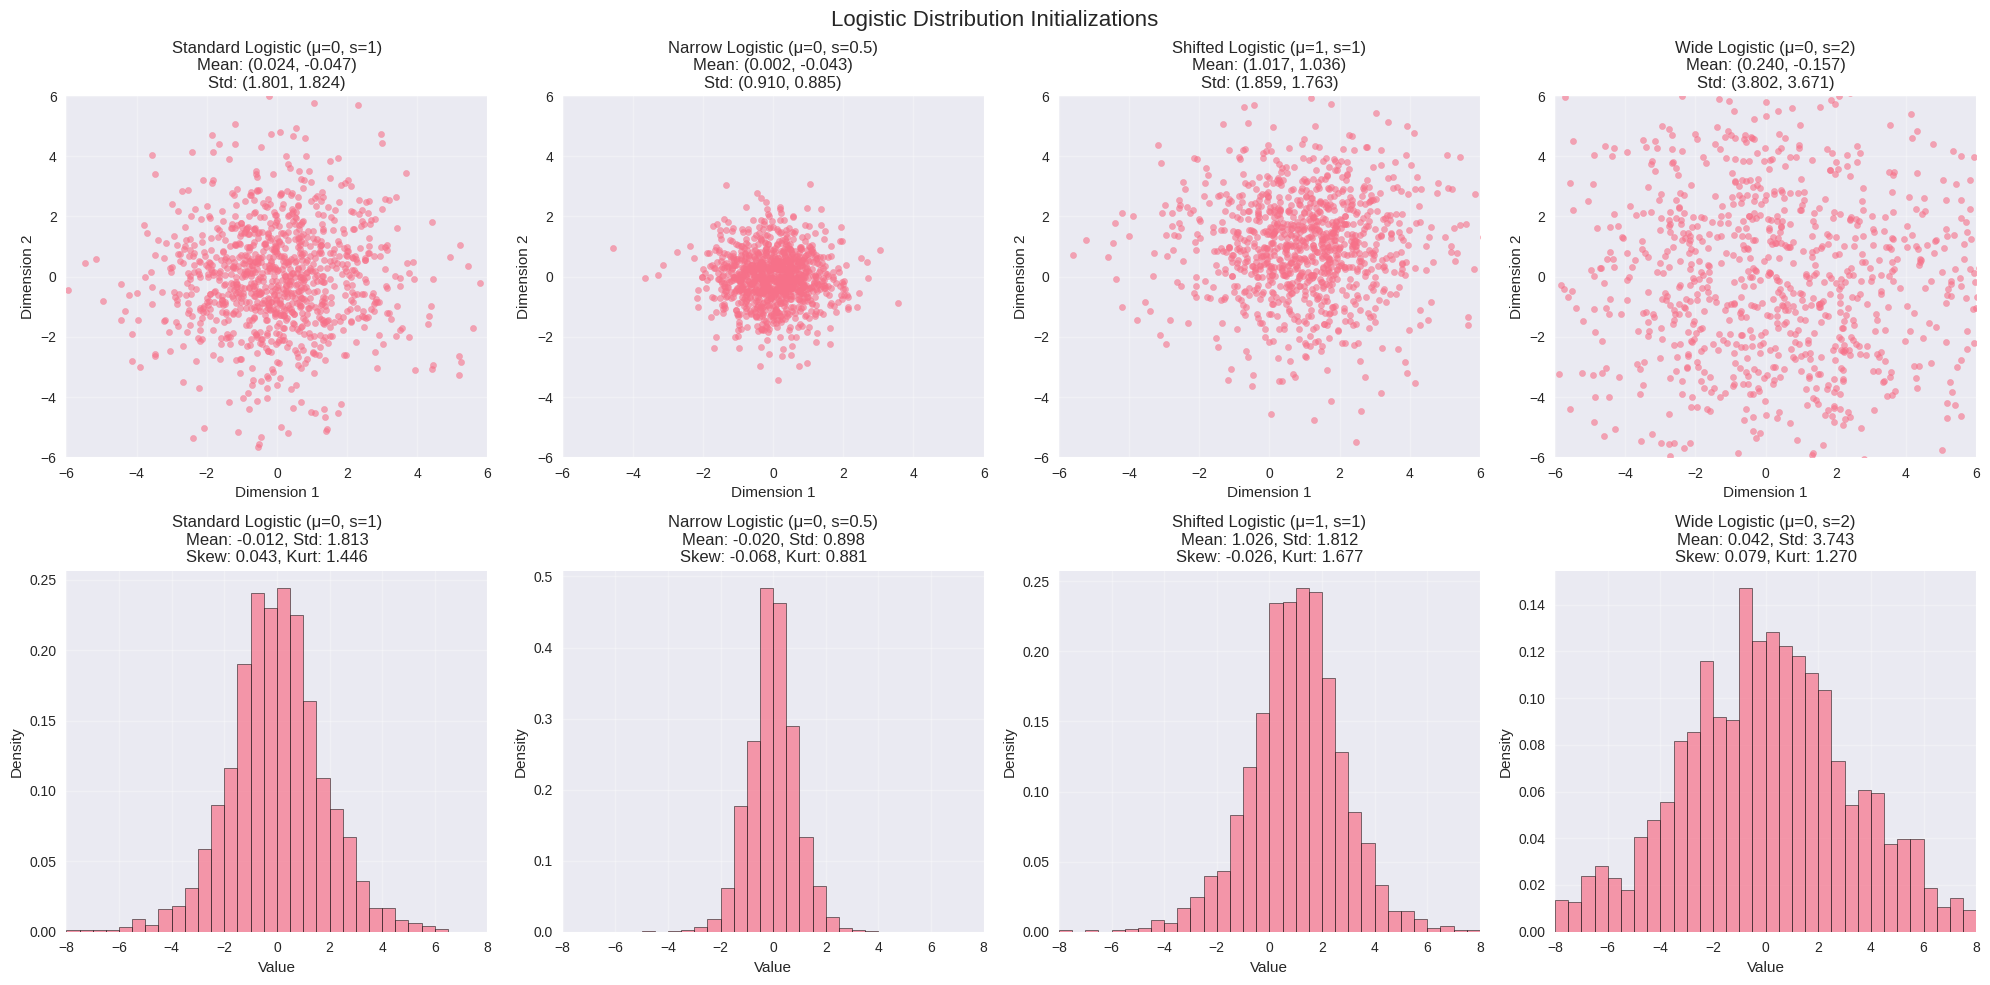

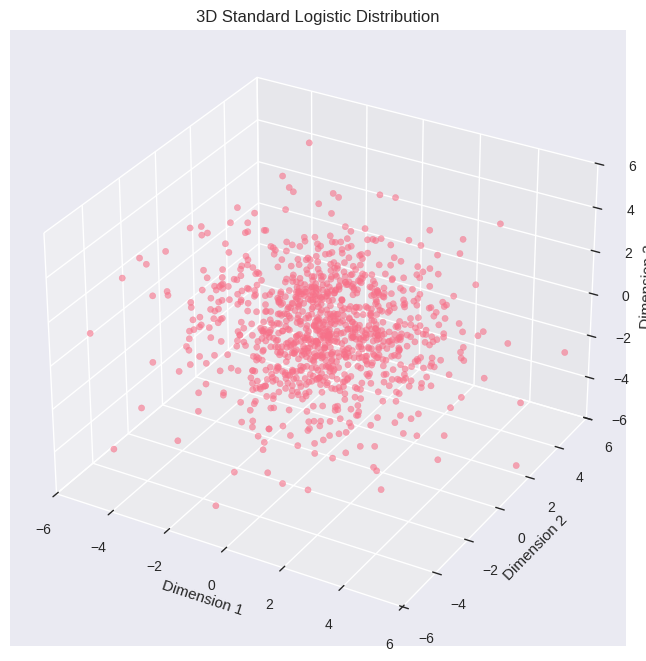


Theoretical vs Empirical Properties:
Mean:      Theoretical = 0.0000, Empirical = 0.0155
Variance:  Theoretical = 3.2899, Empirical = 3.1938
Std Dev:   Theoretical = 1.8138, Empirical = 1.7871
Skewness:  Theoretical = 0.0000, Empirical = 0.0338
Kurtosis:  Theoretical = 1.2000, Empirical = 1.1312


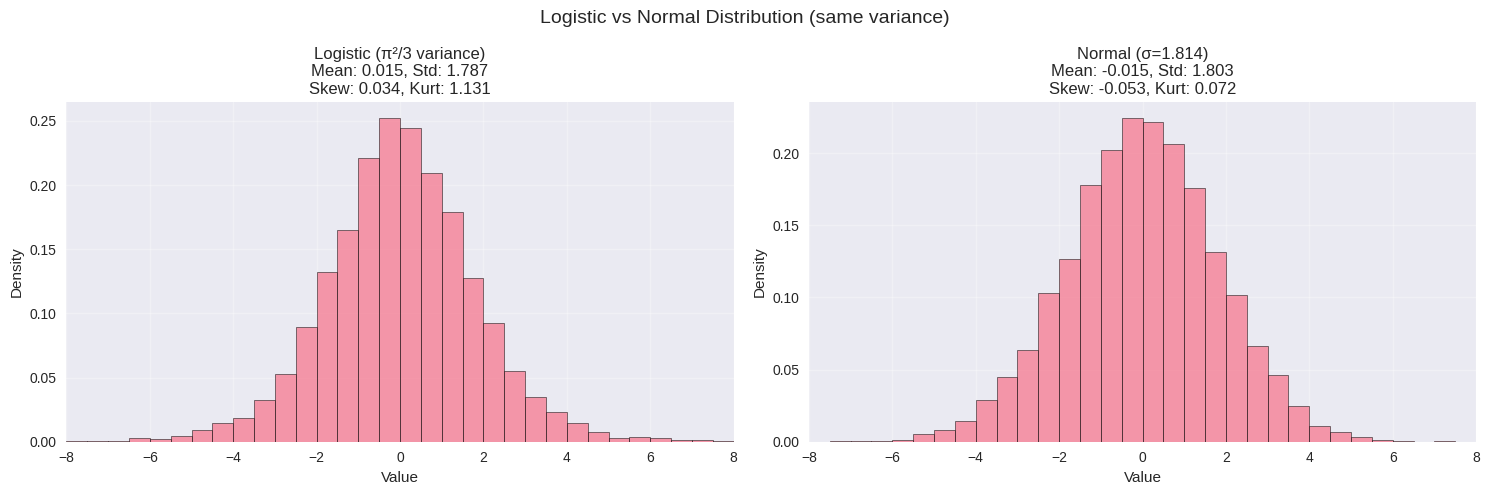


Tail Comparison:
Logistic P(|X| > 3): 0.0949
Normal P(|X| > 3):   0.0981
→ Logistic has heavier tails than normal


In [254]:
print("=== LOGISTIC DISTRIBUTION DEMONSTRATION ===")

# Use CPU device for consistency
device = torch.device('cpu')

# Create logistic distributions with different parameters
logistic_configs = [
    {'loc': 0.0, 'scale': 1.0, 'title': 'Standard Logistic (μ=0, s=1)'},
    {'loc': 0.0, 'scale': 0.5, 'title': 'Narrow Logistic (μ=0, s=0.5)'},
    {'loc': 1.0, 'scale': 1.0, 'title': 'Shifted Logistic (μ=1, s=1)'},
    {'loc': 0.0, 'scale': 2.0, 'title': 'Wide Logistic (μ=0, s=2)'}
]

# 2D visualizations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Logistic Distribution Initializations', fontsize=16)

for i, config in enumerate(logistic_configs):
    # Create representation layer
    layer = RepresentationLayer(
        dim=DIM_2D, 
        n_samples=N_SAMPLES, 
        dist='logistic',
        dist_params={'loc': config['loc'], 'scale': config['scale']},
        device=device
    )
    
    # Print statistics
    print_statistics(layer.z, config['title'])
    
    # Scatter plot with consistent limits
    plot_2d_scatter(layer.z, config['title'], axes[0, i])
    axes[0, i].set_xlim(-6, 6)
    axes[0, i].set_ylim(-6, 6)
    
    # Histogram with consistent limits and bin width
    plot_histogram(layer.z, config['title'], axes[1, i], xlim=(-8, 8), bin_width=0.5)

plt.tight_layout()
plt.show()

# 3D visualization for standard logistic
layer_3d = RepresentationLayer(dim=DIM_3D, n_samples=N_SAMPLES, dist='logistic', device=device)
fig, ax = plot_3d_scatter(layer_3d.z, '3D Standard Logistic Distribution')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(-6, 6)
plt.show()

# Theoretical vs Empirical Properties Comparison
print(f"\nTheoretical vs Empirical Properties:")
print("="*50)

layer_standard = RepresentationLayer(dim=1, n_samples=10000, dist='logistic', device=device)
data_1d = layer_standard.z.detach().cpu().numpy().flatten()

# Theoretical values for standard logistic (μ=0, s=1)
theoretical_mean = 0.0
theoretical_variance = (np.pi**2) / 3  # π²/3 ≈ 3.29
theoretical_std = np.sqrt(theoretical_variance)

print(f"Mean:      Theoretical = {theoretical_mean:.4f}, Empirical = {data_1d.mean():.4f}")
print(f"Variance:  Theoretical = {theoretical_variance:.4f}, Empirical = {data_1d.var():.4f}")
print(f"Std Dev:   Theoretical = {theoretical_std:.4f}, Empirical = {data_1d.std():.4f}")
print(f"Skewness:  Theoretical = 0.0000, Empirical = {stats.skew(data_1d):.4f}")
print(f"Kurtosis:  Theoretical = 1.2000, Empirical = {stats.kurtosis(data_1d):.4f}")  # Excess kurtosis = 6/5 = 1.2

# Compare with normal distribution of same variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Logistic vs Normal Distribution (same variance)', fontsize=14)

# Generate normal with same variance as logistic
normal_std = theoretical_std
normal_samples = torch.randn(10000, device=device) * normal_std
normal_data = normal_samples.detach().cpu().numpy()

# Plot both distributions
plot_histogram(torch.tensor(data_1d).unsqueeze(0), 'Logistic (π²/3 variance)', axes[0], xlim=(-8, 8), bin_width=0.5)
plot_histogram(normal_samples.unsqueeze(0), f'Normal (σ={normal_std:.3f})', axes[1], xlim=(-8, 8), bin_width=0.5)

plt.tight_layout()
plt.show()

print(f"\nTail Comparison:")
print(f"Logistic P(|X| > 3): {2 * (1 - 1/(1 + np.exp(-3))):.4f}")
print(f"Normal P(|X| > 3):   {2 * (1 - stats.norm.cdf(3/normal_std)):.4f}")
print(f"→ Logistic has heavier tails than normal")

## Distribution Comparison Analysis

Compare all distributions side-by-side with standardized parameters.

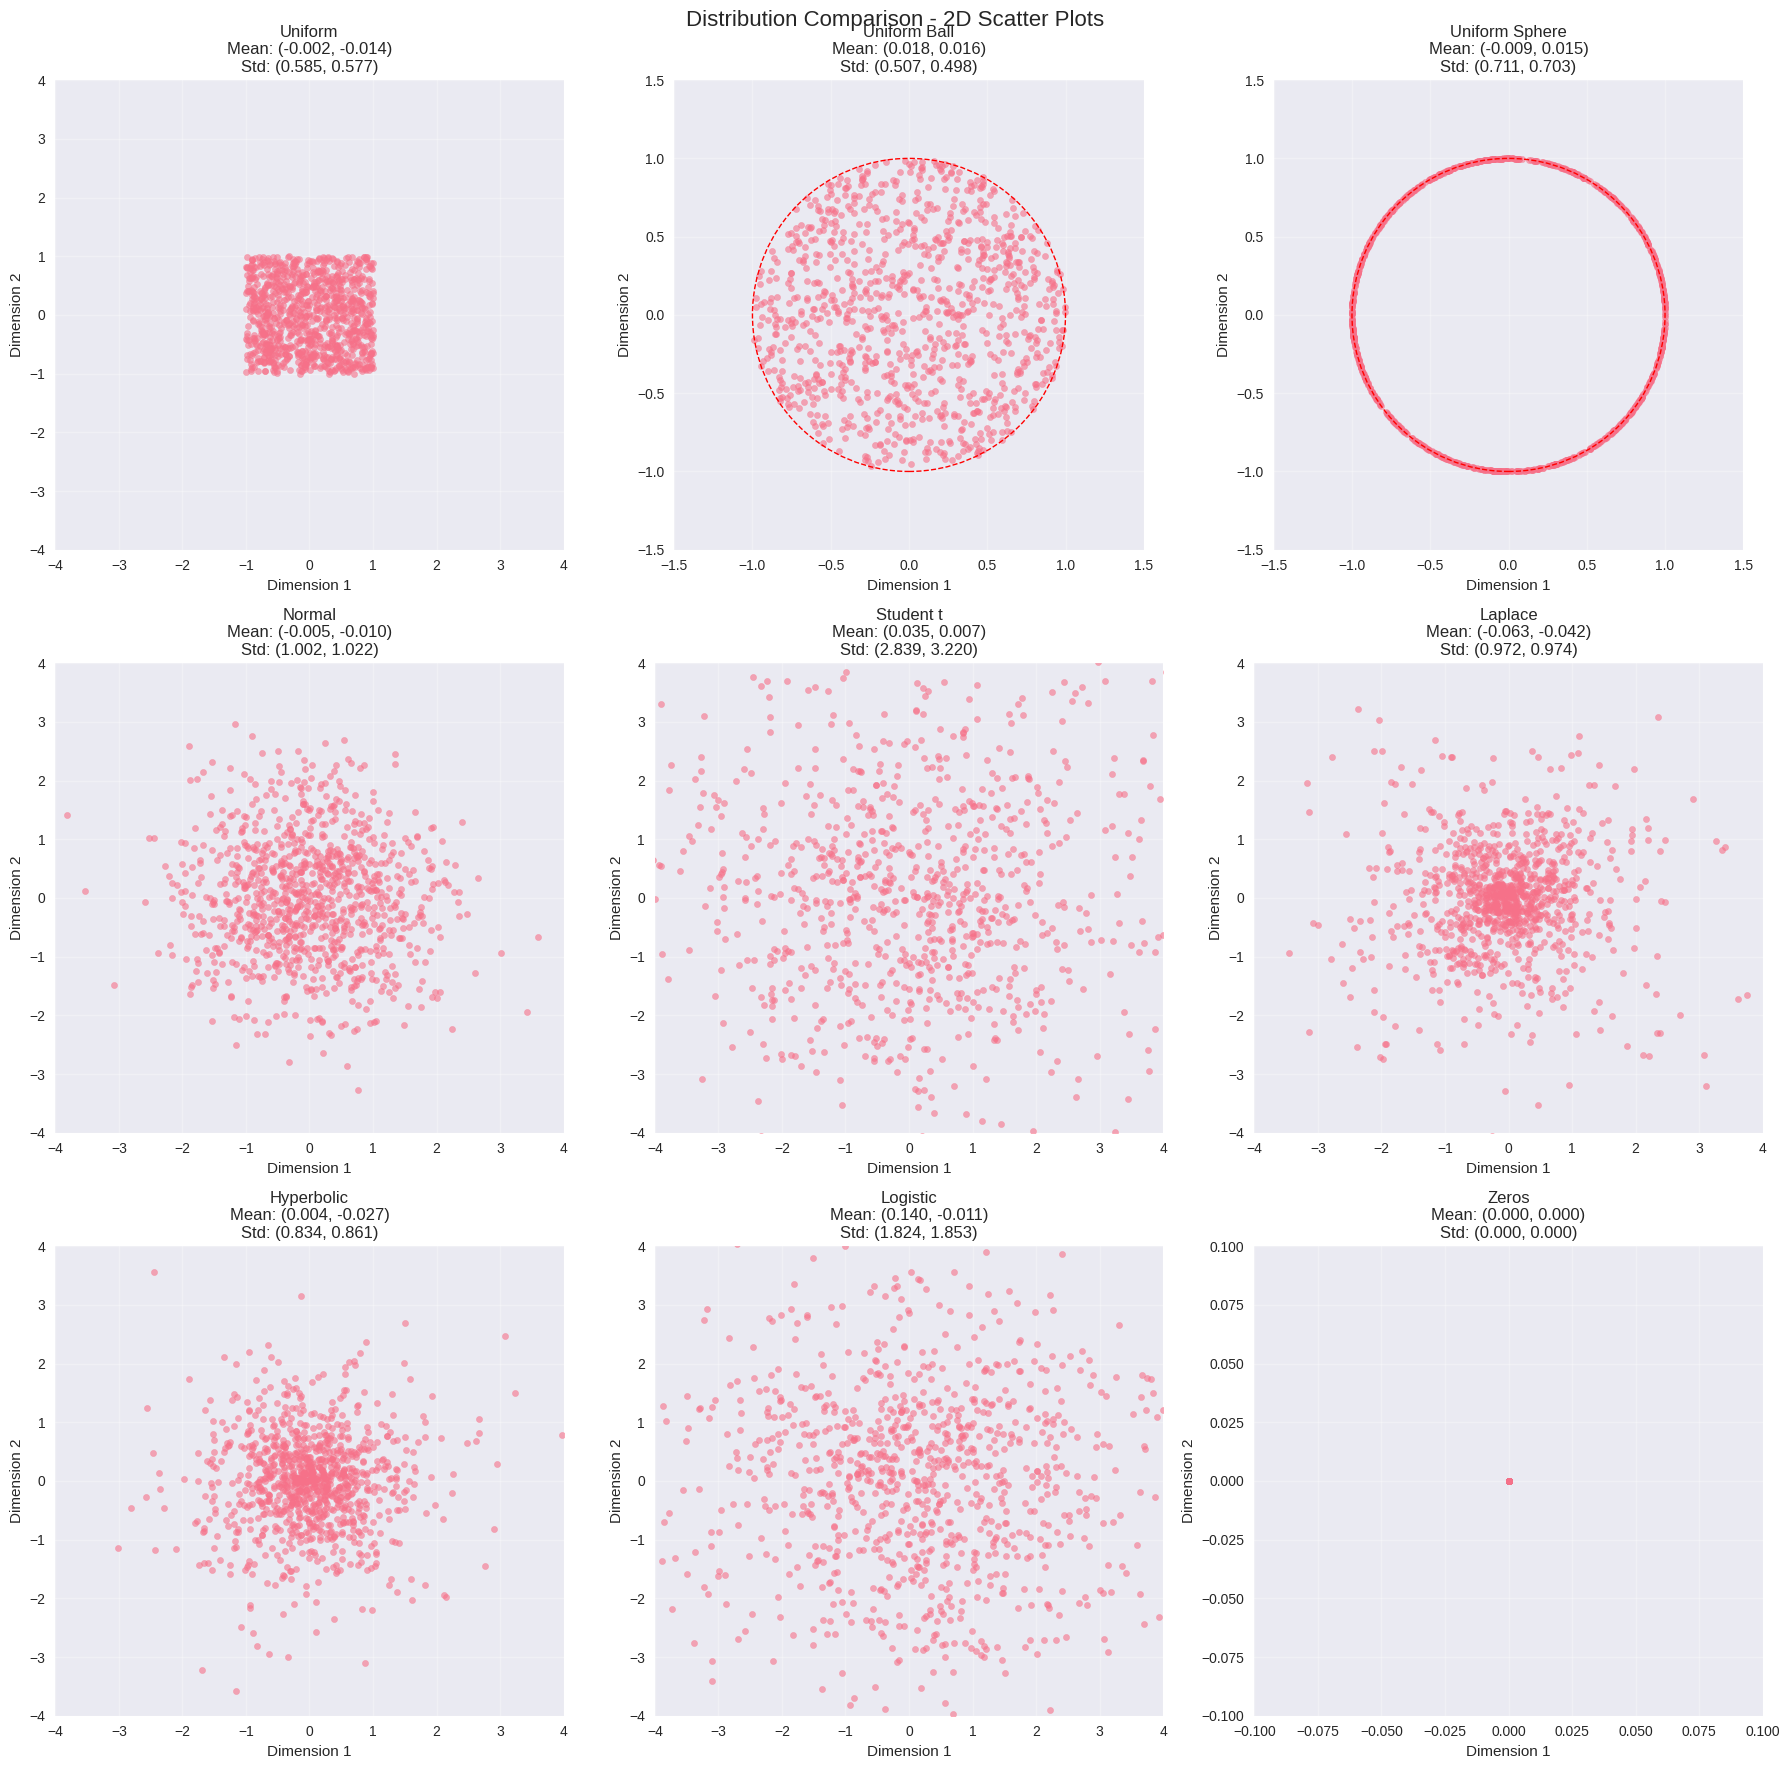

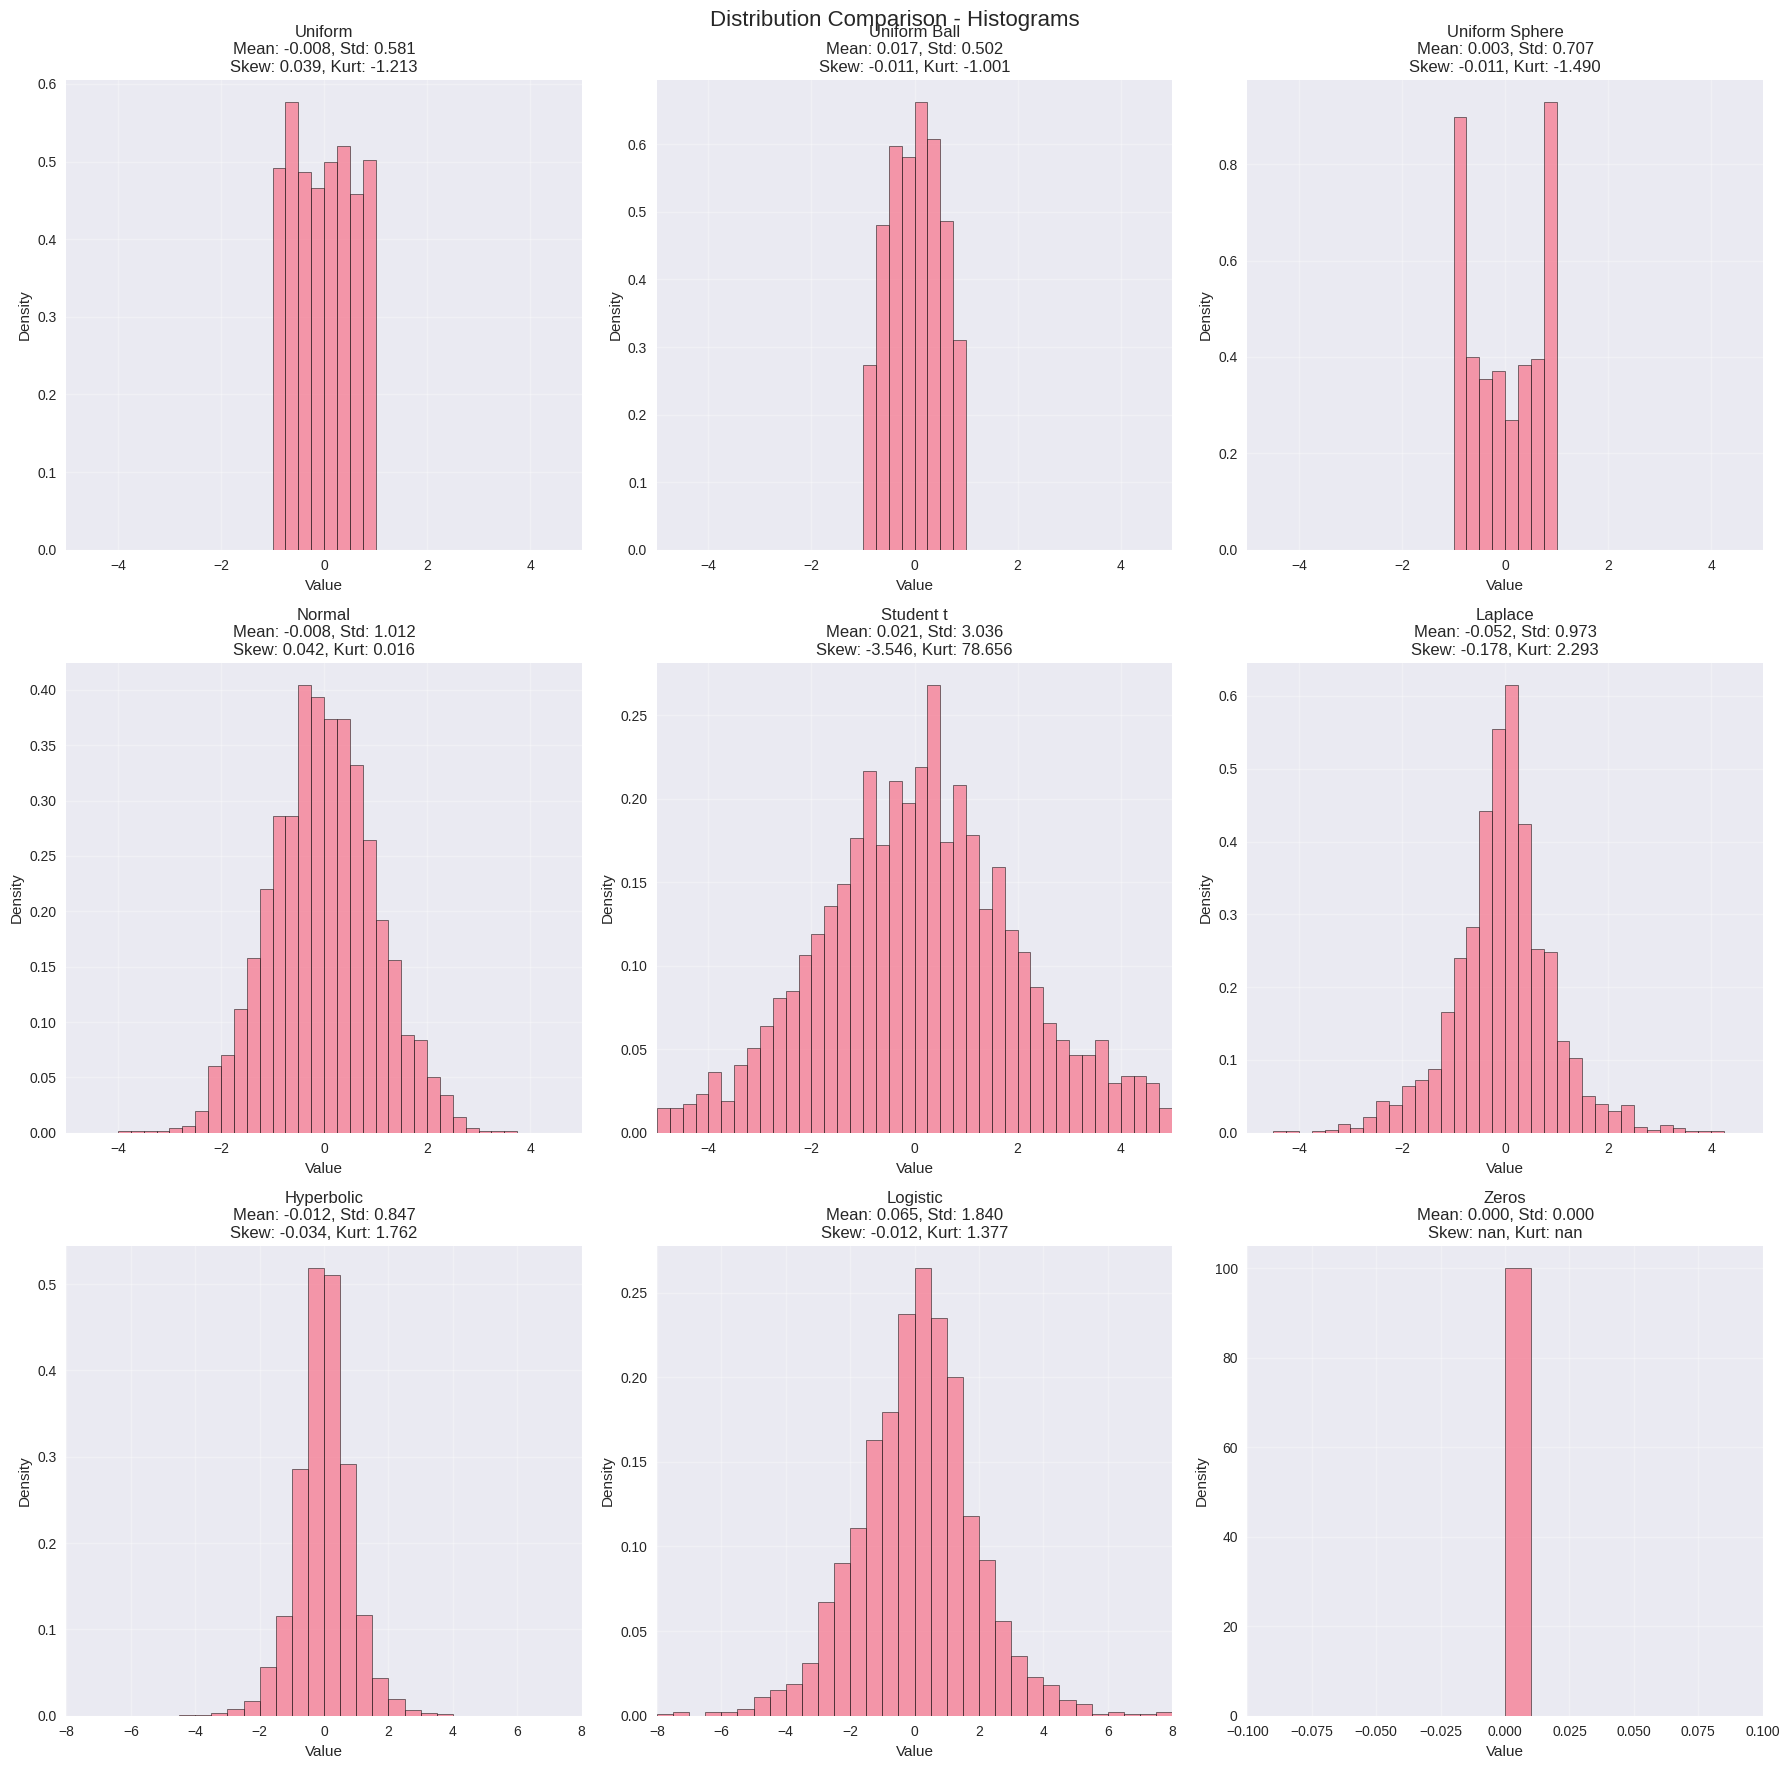


STATISTICAL SUMMARY TABLE
Distribution    Mean     Std      Min      Max      Skew     Kurt     Range   
------------------------------------------------------------------------------------------
Uniform         -0.008   0.581    -1.000   1.000    0.039    -1.213   1.999   
Uniform Ball    0.017    0.502    -0.987   0.999    -0.011   -1.001   1.986   
Uniform Sphere  0.003    0.707    -1.000   1.000    -0.011   -1.490   2.000   
Normal          -0.008   1.012    -3.818   3.594    0.042    0.016    7.413   
Student t       0.021    3.036    -59.626  24.834   -3.546   78.656   84.460  
Laplace         -0.052   0.973    -6.282   4.066    -0.178   2.293    10.348  
Hyperbolic      -0.012   0.847    -4.465   3.978    -0.034   1.762    8.443   
Logistic        0.065    1.840    -8.015   8.952    -0.012   1.377    16.967  
Zeros           0.000    0.000    0.000    0.000    nan      nan      0.000   
------------------------------------------------------------------------------------------



In [255]:
# Use CPU device for consistency
device = torch.device('cpu')

# Create all distributions with standardized parameters in the new order:
# uniform, uniform ball, uniform sphere, normal, student, laplace, hyperbolic, logistic, zeros
distributions = {
    'Uniform': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='uniform', device=device),
    'Uniform Ball': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='uniform_ball', device=device),
    'Uniform Sphere': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='uniform_sphere', device=device),
    'Normal': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='normal', device=device),
    'Student t': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='student_t', device=device),
    'Laplace': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='laplace', device=device),
    'Hyperbolic': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='hyperbolic', device=device),
    'Logistic': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='logistic', device=device),
    'Zeros': RepresentationLayer(dim=DIM_2D, n_samples=N_SAMPLES, dist='zeros', device=device)
}

# 2D Scatter plot comparison
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Distribution Comparison - 2D Scatter Plots', fontsize=16)
axes = axes.flatten()

for i, (name, layer) in enumerate(distributions.items()):
    if i < len(axes):
        plot_2d_scatter(layer.z, name, axes[i])
        # Set consistent axis limits (special cases for some distributions)
        if name == 'Zeros':
            axes[i].set_xlim(-0.1, 0.1)
            axes[i].set_ylim(-0.1, 0.1)
        elif name in ['Uniform Sphere', 'Uniform Ball']:
            axes[i].set_xlim(-1.5, 1.5)
            axes[i].set_ylim(-1.5, 1.5)
            axes[i].set_aspect('equal')
            # Add circle for sphere/ball visualization
            circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linestyle='--', linewidth=1)
            axes[i].add_patch(circle)
        else:
            axes[i].set_xlim(-4, 4)
            axes[i].set_ylim(-4, 4)

plt.tight_layout()
plt.show()

# Histogram comparison
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Distribution Comparison - Histograms', fontsize=16)
axes = axes.flatten()

for i, (name, layer) in enumerate(distributions.items()):
    if i < len(axes):
        if name == 'Zeros':  # Zeros needs special handling
            plot_histogram(layer.z, name, axes[i], xlim=(-0.1, 0.1), bin_width=0.01)
        elif name in ['Hyperbolic', 'Logistic']:  # Heavy-tailed distributions
            plot_histogram(layer.z, name, axes[i], xlim=(-8, 8), bin_width=0.5)
        else:  # Standard range for most distributions
            plot_histogram(layer.z, name, axes[i], xlim=(-5, 5), bin_width=0.25)

plt.tight_layout()
plt.show()

# Statistical summary table
print("\n" + "="*90)
print("STATISTICAL SUMMARY TABLE")
print("="*90)
print(f"{'Distribution':<15} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Skew':<8} {'Kurt':<8} {'Range':<8}")
print("-"*90)

for name, layer in distributions.items():
    data_flat = layer.z.detach().cpu().numpy().flatten()
    data_range = data_flat.max() - data_flat.min()
    print(f"{name:<15} {data_flat.mean():<8.3f} {data_flat.std():<8.3f} {data_flat.min():<8.3f} {data_flat.max():<8.3f} {stats.skew(data_flat):<8.3f} {stats.kurtosis(data_flat):<8.3f} {data_range:<8.3f}")

print("-"*90)

# Distribution family groupings
print(f"\nDistribution Family Characteristics:")
print("="*50)
print("  UNIFORM FAMILY:")
print("  • Uniform: Rectangular, bounded support, constant density")
print("  • Uniform Ball: Spherical volume, radial concentration in high dims")  
print("  • Uniform Sphere: Surface only, all points equidistant from center")

print("\n  GAUSSIAN FAMILY:")
print("  • Normal: Light tails, maximum entropy for given variance")
print("  • Student t: Heavy tails, robust to outliers")
print("  • Laplace: Exponential tails, sparsity-promoting")

print("\n  Other:")
print("  • Hyperbolic: Heavy tails, can be asymmetrical")
print("  • Logistic: Heavy tails, S-shaped CDF, sigmoid-related")
print("  • Zeros: Deterministic initialization at origin")
